<h1>Introduction</h1>

Nearly 10 million people will die from cancer in 2020, making it the leading cause of death in the world.
Breast, lung, colon, and prostate cancers are the most common. Tobacco use, obesity, alcohol consumption, low fruit and vegetable intake, and inactivity all contribute to a third of cancer deaths. Human papillomavirus (HPV) and hepatitis are two of the most common cancer-causing infections in low- and middle-income countries. Early detection and effective treatment are key to curing many types of cancer.

Precancerous lesions and malignant tumors are the result of a multi-stage process in which normal cells transform into cancerous ones. The interaction between a person's genetics and three types of external agents results in these modifications including ultraviolet and ionizing radiation, chemical carcinogens such as asbestos, alcohol, aflatoxin, and arsenic, as well as biological carcinogens such as infections from certain viruses, bacteria or parasites.

Therefore, our team will construct a model to determine whether a certain cell image indicates a malignant cell or not by classifying photos in this manner (isCancerous). Moreover, we build another model for classification the unlabel image of the extra data to organized the image into groups based on cell type, such as fibroblast, inflammatory, epithelial or others. For completing the tasks, we have two dataset which are main and extra, and the main data consists of 9896 images, the extra data have 10384 images(all of these images are in the size of 27x27x3). In addition, two important column that we need to take into account are the iscancerous and the cell type column. The iscancerous column represents if the cell is cancerous or not, and the cell type column presents the label of the image.

Reference: WHO 2022, ‘Cancer’, WHO, 3 February, viewed 5 May 2022, <https://www.who.int/news-room/fact-sheets/detail/cancer>.

In [330]:
from __future__ import print_function
import seaborn as sns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import h5py
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
import tensorflow.keras
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [156]:
print('# File sizes')
for f in os.listdir("Image_classification_data"):
    if not os.path.isdir('Image_classification_data' + f):
        print(f.ljust(30) + str(round(os.path.getsize('Image_classification_data/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize('Image_classification_data/'+f+'/'+x)/1000000 for x in os.listdir('Image_classification_data/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
.DS_Store                     0.01MB
patch_images                  0.65MB
data_labels_mainData.csv      0.33MB
patch_images.zip              47.81MB
data_labels_extraData.csv     0.22MB


In [157]:
data_main = pd.read_csv("Image_classification_data/data_labels_mainData.csv")
data_extra  = pd.read_csv("Image_classification_data/data_labels_extraData.csv")
data_combine = pd.concat([data_main, data_extra], ignore_index=True)

In [158]:
data_combine.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


In [159]:
data_main['filePath'] = "Image_classification_data/patch_images/" + data_main.ImageName
data_extra['filePath'] = "Image_classification_data/patch_images/" + data_extra.ImageName
data_combine['filePath'] = "Image_classification_data/patch_images/" + data_combine.ImageName

In [160]:
data_combine.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,filePath
0,22405,1,22405.png,fibroblast,0.0,0,Image_classification_data/patch_images/22405.png
1,22406,1,22406.png,fibroblast,0.0,0,Image_classification_data/patch_images/22406.png
2,22407,1,22407.png,fibroblast,0.0,0,Image_classification_data/patch_images/22407.png
3,22408,1,22408.png,fibroblast,0.0,0,Image_classification_data/patch_images/22408.png
4,22409,1,22409.png,fibroblast,0.0,0,Image_classification_data/patch_images/22409.png


In [161]:
data_combine.isnull().sum()

InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
filePath            0
dtype: int64

In [162]:
print("Shape of main set: ", data_main.shape)
print("Shape of extra set: ", data_extra.shape)
print("Shape of combine set: ", data_combine.shape)

Shape of main set:  (9896, 7)
Shape of extra set:  (10384, 5)
Shape of combine set:  (20280, 7)


In [163]:
#check many unique patients are in the dataset:
len(data_combine['InstanceID'].unique())

20280

In [164]:
len(data_combine['ImageName'].unique())

20280

In [165]:
data_combine.dtypes

InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
filePath         object
dtype: object

In [166]:
from termcolor import colored
for col in data_main.columns:
    print(col + ":" + colored(str(len(data_main[col].unique())), 'yellow'))

InstanceID:9896
patientID:60
ImageName:9896
cellTypeName:4
cellType:4
isCancerous:2
filePath:9896


In [167]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

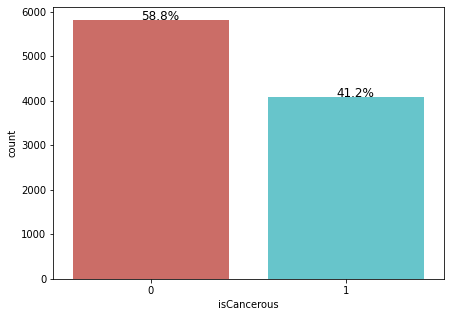

In [168]:
plt.figure(figsize= (7,5))
ax = sns.countplot(x = 'isCancerous', data = data_main, palette='hls')
without_hue(ax, data_main.isCancerous)

In the main data, the not cancerous represent by 0, and the cancerous represent by 1. The ratio of 0 is 58.8% and it is 41.2% for the 1. Base on the research, unbalanced describes a categorization data set with unbalanced class proportions. Classes that make up the bulk of the data set are known as majority classes. Classes that constitute a smaller proportion are minority classes. The imbalance in dataset occur when the ratio of the minority data is range from 1% to 40%. Moreover, we can call it the degree of imbalance, from 20% to 40% is mild, from 1% to 20% is moderate, and 1% is extreme. Therefore, the different between the not cancerous and cancerous is 17% which we can get to the final evaluate that the main dataset is not imbalance. 

Reference: Google Developers 2021, ‘Imbalanced Data | Data Preparation and Feature Engineering for Machine Learning’, Google Developers, 1 November, viewed 3 May 2022, <https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data?fbclid=IwAR377zM8TFK41MJWmUAaGHxkLfeu9XFDOLxH7U8P3JWjvXHThDiuIv_34cI>.

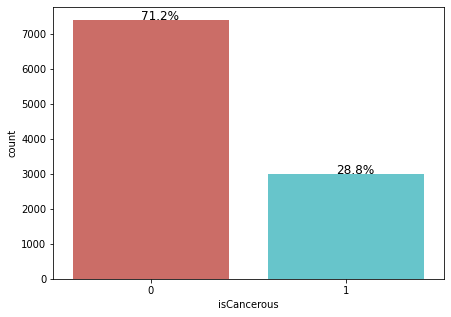

In [15]:
plt.figure(figsize= (7,5))
ax = sns.countplot(x = 'isCancerous', data = data_extra, palette='hls')
without_hue(ax, data_extra.isCancerous)

As the description of the imbalance data had been stated, the graph demonstrates the percentage of not malignant is approximately 30 percent of the dataset which had meet the mild degree(20% - 40%). Moreover, the training efficient machine learning models can be challenging if there aren't enough samples from the class of interest because of class imbalance. It is difficult to train a machine learning model for fraud detection since the number of fraudulent transactions is so small compared to the number of legitimate transactions. Therefore, it is neccessary to increase the data of the cancerous to make it balance, and one way that we have try is to combine the data of the main and extra into one file to see if the combination data is balance or not.  

Reference: Hackernoon 2021, ‘What is Data Imbalance in Machine Learning?’, HackerNoon, 2 June, viewed 2 May 2022, <https://hackernoon.com/what-is-data-imbalance-in-machine-learning-932f34n8?fbclid=IwAR18U19w93kqjhZmRbXqN5KRTjFfkVodM4RC-XvpqG27l0D96b_OhW8KCOk>.

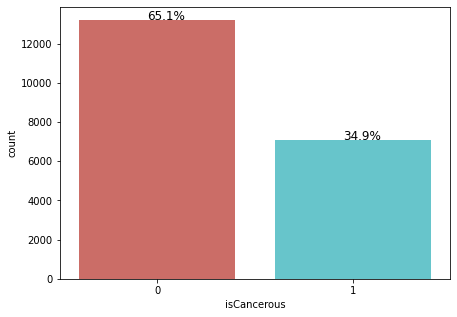

In [170]:
plt.figure(figsize= (7,5))
ax = sns.countplot(x = 'isCancerous', data = data_combine, palette='hls')
without_hue(ax, data_combine.isCancerous)

For the combination dataset, the cancerous quantity is increase but it is still significantly imbalance (34.9% compare to 65.1%). In order to solve this problem, we could apply the data augmentation technique which is new data points can be generated from existing data by using techniques to artificially inflate datasets. Deep learning models can be used to generate new data points by making minor adjustments to the data. For data augmentation, performing minor adjustments on visual data is popular. It is also necessary to employ GANs to generate new synthetic data. Classic image processing activities for data augmentation are:

- Padding
- Random rotating
- Re-scaling,
- Vertical and horizontal flipping
- Translation ( image is moved along X, Y direction)
- Cropping
- Zooming

Reference: Hackernoon 2021, ‘What is Data Imbalance in Machine Learning?’, HackerNoon, 2 June, viewed 2 May 2022, <https://hackernoon.com/what-is-data-imbalance-in-machine-learning-932f34n8?fbclid=IwAR18U19w93kqjhZmRbXqN5KRTjFfkVodM4RC-XvpqG27l0D96b_OhW8KCOk>.

Takimoglu, A 2021, ‘What is Data Augmentation? Techniques & Examples in 2022’, AI Multiple, 20 April, viewed 2 May 2022, <
https://research.aimultiple.com/data-augmentation/?fbclid=IwAR2G-scojyAm2g9zplF_T-vWqidNYINvlHd9Zcn9FEtq1mAfglbhVMZHWcU>.
                    
          

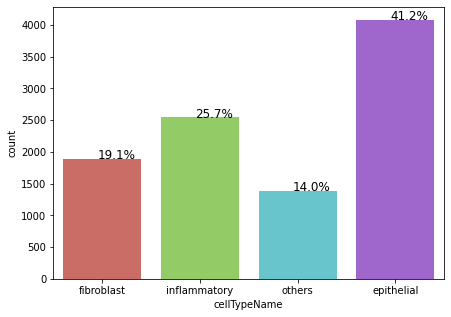

In [17]:
plt.figure(figsize= (7,5))
ax = sns.countplot(x = 'cellTypeName', data = data_main, palette='hls')
without_hue(ax, data_main.cellTypeName)

This graph illustrates the quantity of each cell type in the main dataset, and from this data we could observe if the data between the cell is balance or not. This is similar to the compare of not cancerous and cancerous. In this case, the fibroblast and the inflammatory are balance with each other, the others is imbalance compare with the others 3, and epithelial have the highest amount. Therefore, the data augmentation technique could apply which are undersampling and oversampling. These technique are the most commonly used data-driven strategies for dealing with classes that are unbalanced. Undersampling is the practice of selecting data from the majority class for the sole purpose of training another group of students (i.e. the remainder of the data will not be used during training). Oversampling includes adding copies of samples in the minority class to the training dataset. Statistical approaches have been developed to better depict the underlying class distributions when picking or discarding samples, but the original sampling methods were done at random.

Reference: Hackernoon 2021, ‘What is Data Imbalance in Machine Learning?’, HackerNoon, 2 June, viewed 2 May 2022, <https://hackernoon.com/what-is-data-imbalance-in-machine-learning-932f34n8?fbclid=IwAR18U19w93kqjhZmRbXqN5KRTjFfkVodM4RC-XvpqG27l0D96b_OhW8KCOk>.

/Users/vananhhuynh/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


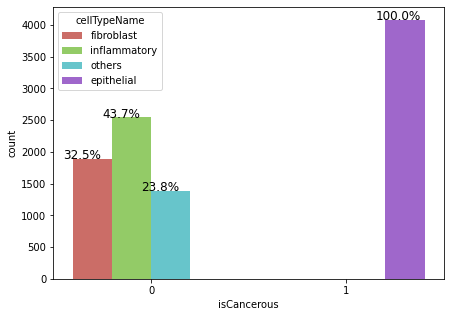

In [172]:
plt.figure(figsize= (7,5))
ax = sns.countplot( 'isCancerous',hue = 'cellTypeName' , data = data_main, palette='hls')
with_hue(ax, data_main.isCancerous, 2, 4)

This graph presents which cell type cause cancerous and it is the epithelial. On the other hand, the rest cell do not cause cancerous. While a small skew in the balance levels is acceptable, a larger disparity leads to incorrect classifier training and incorrect predictions. The current Big Data scenario has the same class ratio (imbalance level) as ordinary data, but the actual instance levels tend to increase due to the data's size. Major classes have high representation while lesser classes have low representation. This leads to overtraining of main classes and undertraining of lesser classes. When given with such Big Data, a classifier tends to predict majority classes well, but not minority classes well, lowering the model's reliability.

Reference: Ripublication, 2022, viwed at 12 May 2022 <https://www.ripublication.com/ijcir17/ijcirv13n9_09.pdf>

/Users/vananhhuynh/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


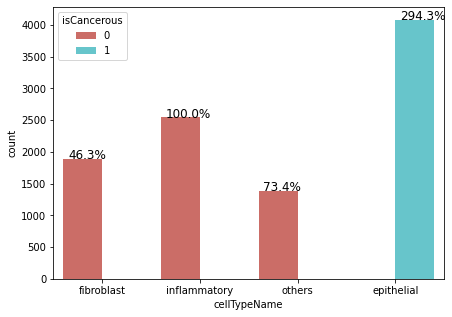

In [173]:
plt.figure(figsize= (7,5))
ax = sns.countplot( 'cellTypeName',hue = 'isCancerous' , data = data_main, palette='hls')
with_hue(ax, data_main.cellTypeName, 4, 2)

In [174]:
data_main[data_main['isCancerous'] == 1]

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,filePath
449,276,5,276.png,epithelial,2,1,Image_classification_data/patch_images/276.png
450,277,5,277.png,epithelial,2,1,Image_classification_data/patch_images/277.png
451,278,5,278.png,epithelial,2,1,Image_classification_data/patch_images/278.png
452,279,5,279.png,epithelial,2,1,Image_classification_data/patch_images/279.png
453,280,5,280.png,epithelial,2,1,Image_classification_data/patch_images/280.png
...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,Image_classification_data/patch_images/1625.png
9892,1626,60,1626.png,epithelial,2,1,Image_classification_data/patch_images/1626.png
9893,1627,60,1627.png,epithelial,2,1,Image_classification_data/patch_images/1627.png
9894,1628,60,1628.png,epithelial,2,1,Image_classification_data/patch_images/1628.png


In [175]:
data_main[(data_main['cellTypeName'] == 'epithelial') & (data_main['isCancerous'] == 1)].shape

(4079, 7)

Show some images sample

In [176]:
filePath = data_main.filePath

In [177]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

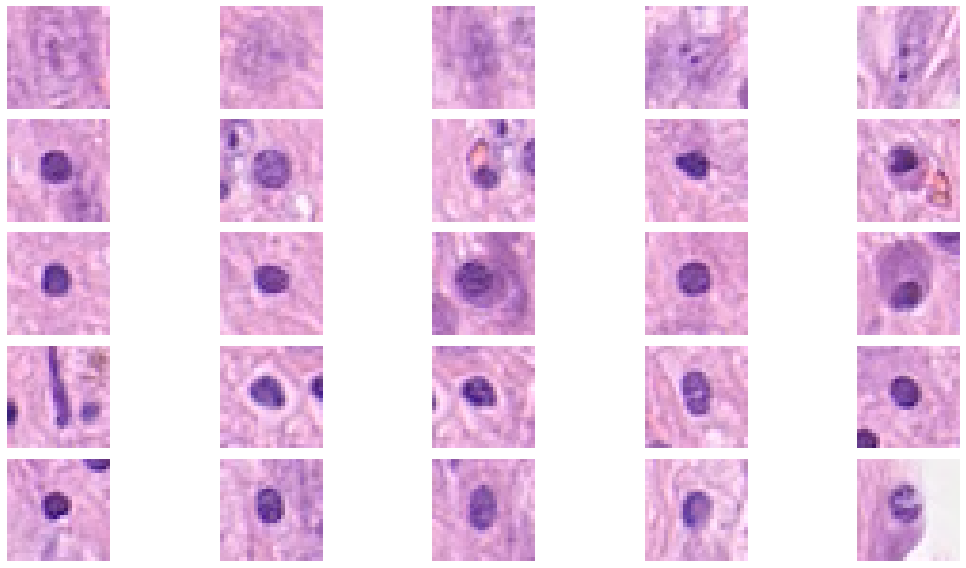

In [178]:
#!pip install opencv-python
import cv2
display_multiple_img(filePath[100:150], 5, 5)

Dimensions and 2D Histogram
Just look at image dimensions, confirm it's 3 band (RGB), byte scaled (0-255).

In [179]:
first = cv2.imread(filePath[0])
dims = np.shape(first)
print(dims)

(27, 27, 3)


In [180]:
np.min(first), np.max(first)

(78, 255)

In [181]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))

(729, 3)


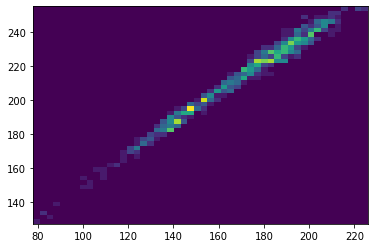

In [182]:
_ = plt.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

## Color distributed 

Depending on our intended use for an image, one approach of evaluating its quality is to examine the distribution of its colors.

This is useful to check if a pure color is present in the image, and for example is the point of the picture: a spike at the extreme end of the histogram for this color demonstrates that the color is present in its pure form on the image (a lot of pixels having a high value for this color) (a lot of pixels having a high value for this color).

It might also help to understand if the dataset is fit to a given purpose. It is well knowledge that the color distribution on a traffic sign indicates the type of sign it is (red for a ban, white for a risk or an obligation, etc...), and this can be useful in tasks such as traffic sign recognition. A model for recognizing traffic signs can be built using shape analysis and shape analysis. The histograms of the values of the various hues can be plotted in the same way as the grayscale histogram.

We can observe that the three colors in this cell image are less mixed, indicating that the picture contains primarily pink rather than a single dominant color. The blue curve travels a bit higher in the value range than the other colors: we observe some image having the white background.

Reference: Www3 tuhh de, 2022. Edge detection — Data Quality Explored, viewed 12 May 2022 <https://www3.tuhh.de/sts/hoou/data-quality-explored/2-2-2-edge.html> 

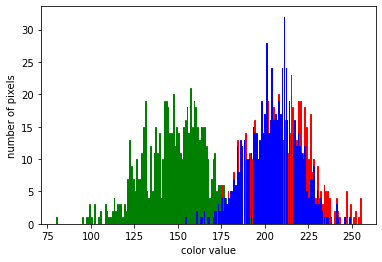

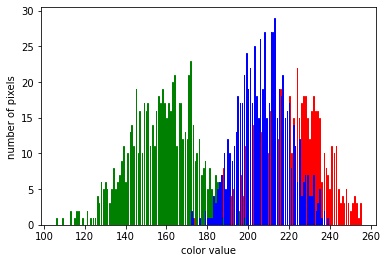

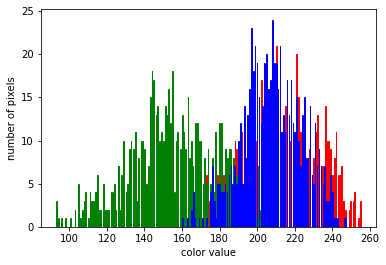

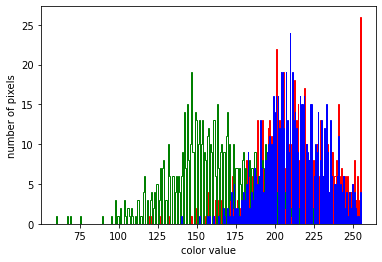

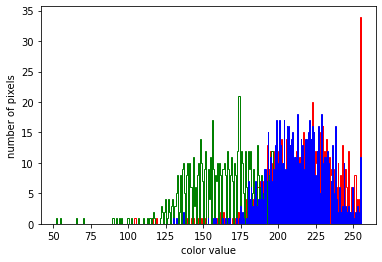

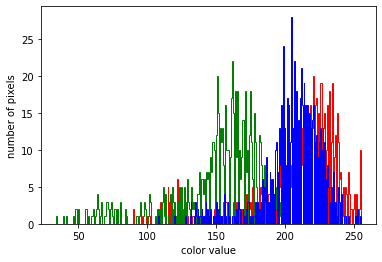

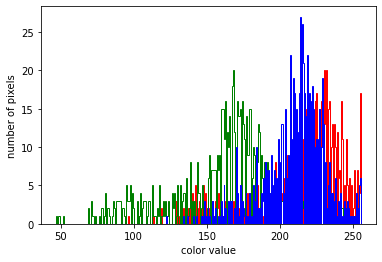

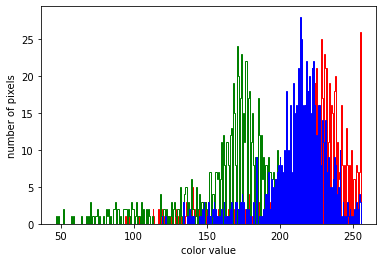

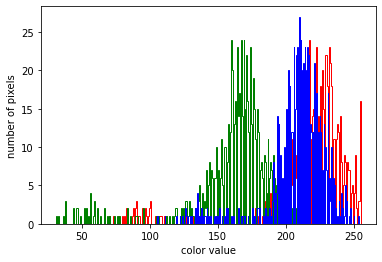

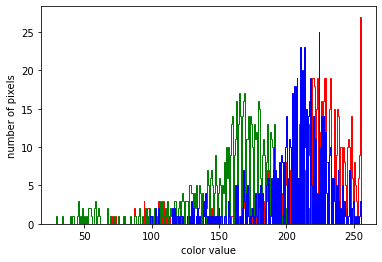

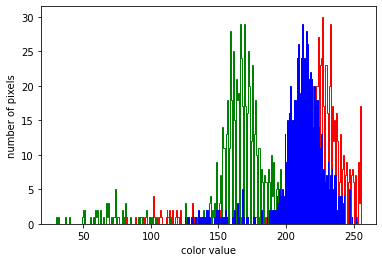

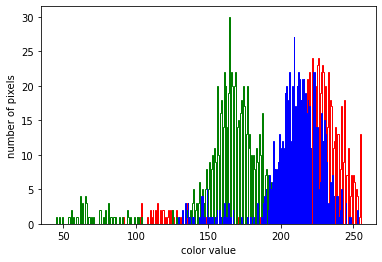

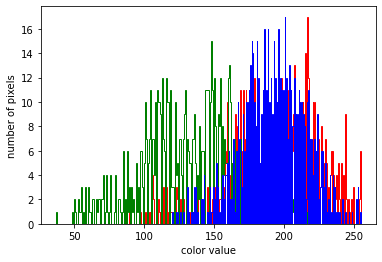

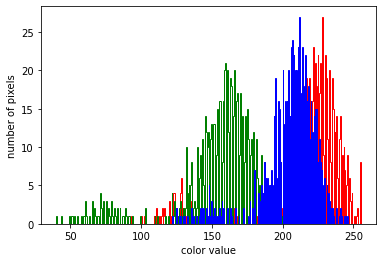

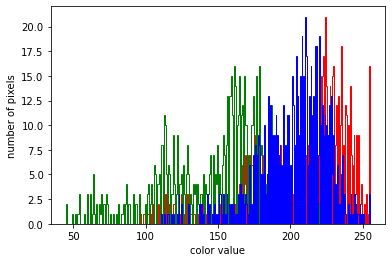

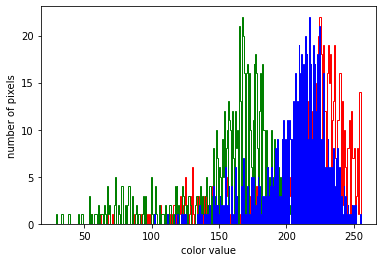

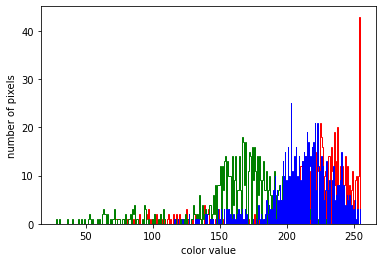

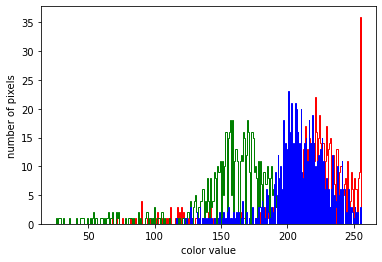

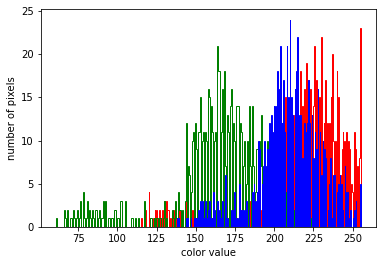

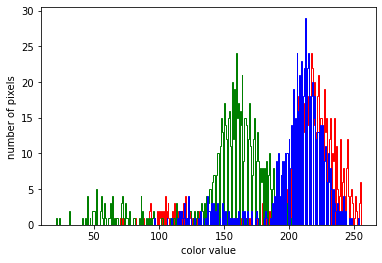

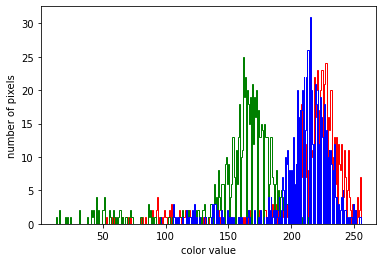

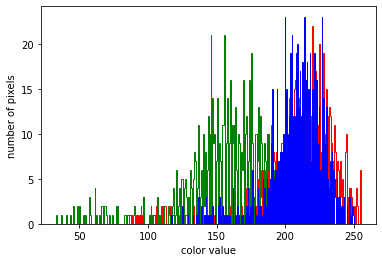

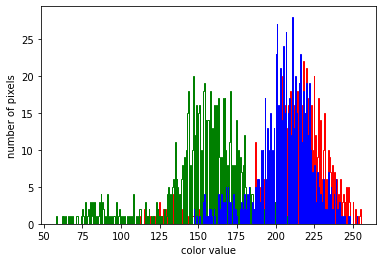

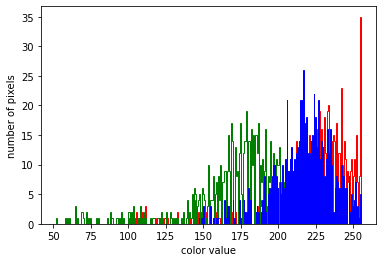

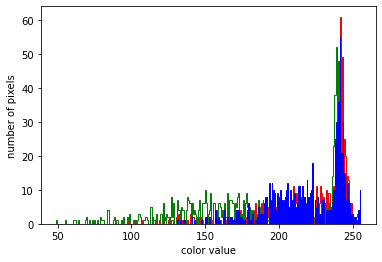

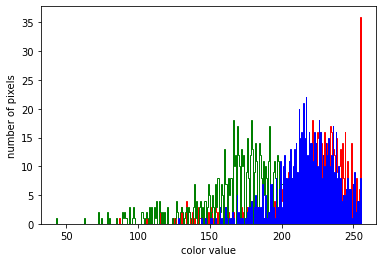

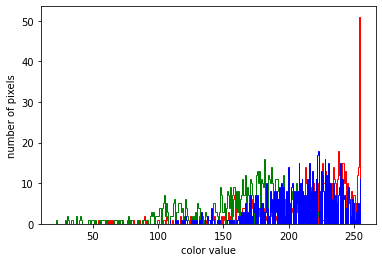

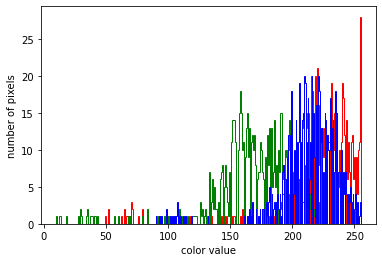

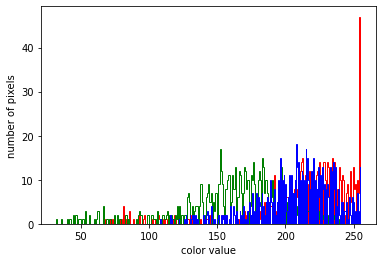

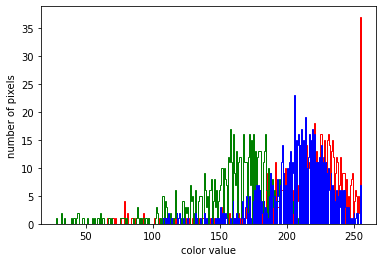

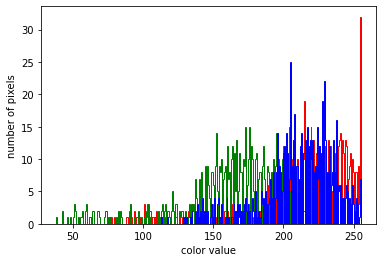

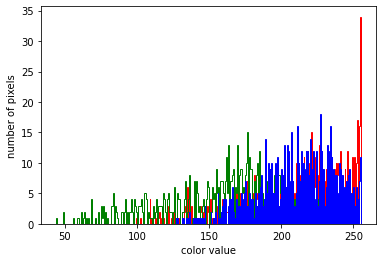

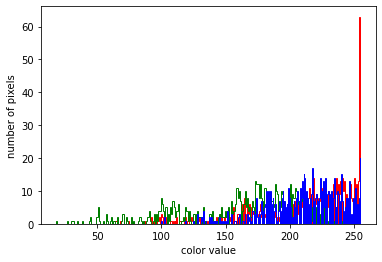

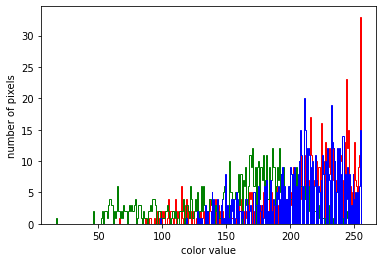

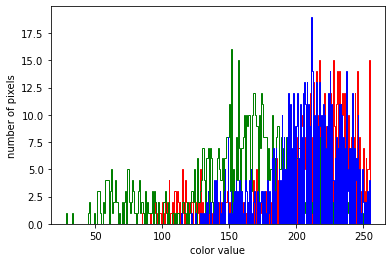

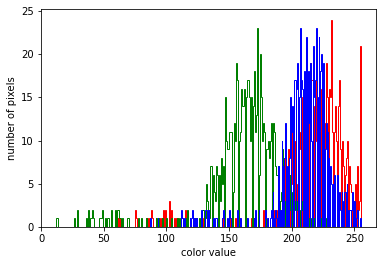

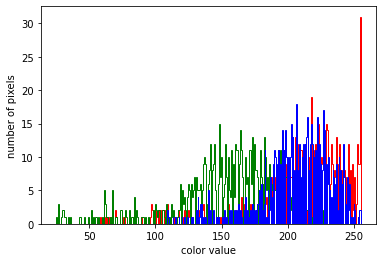

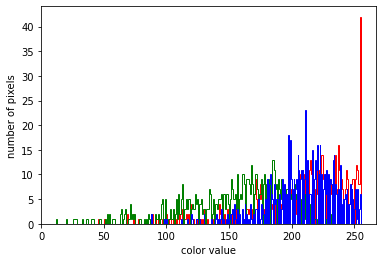

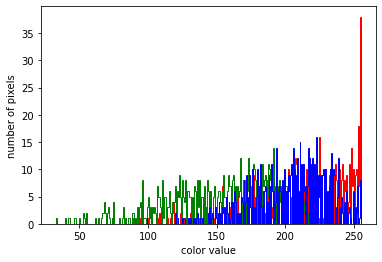

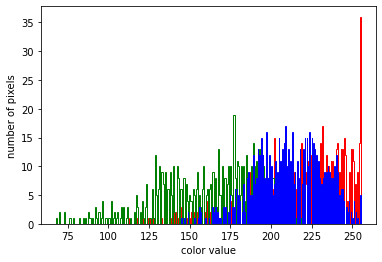

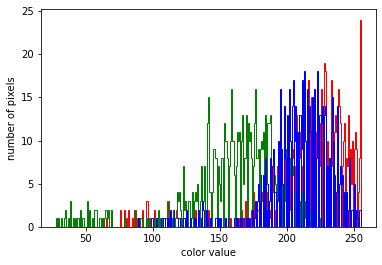

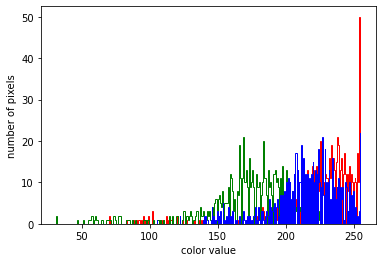

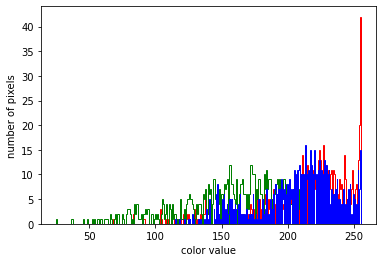

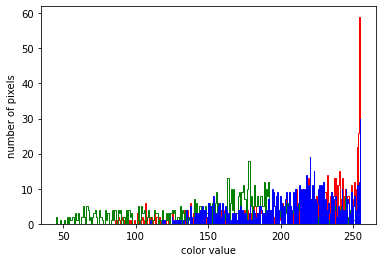

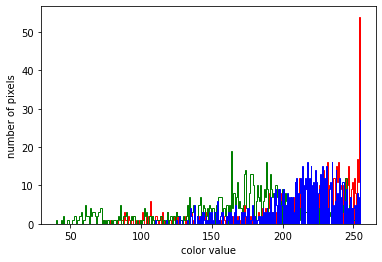

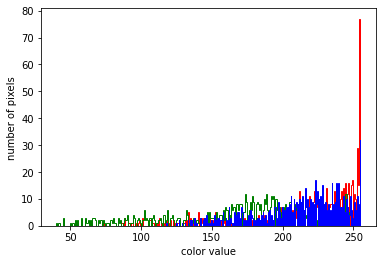

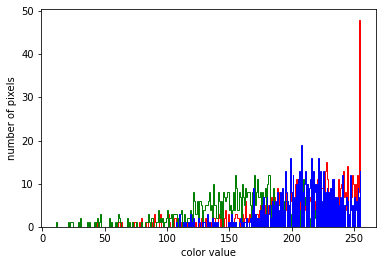

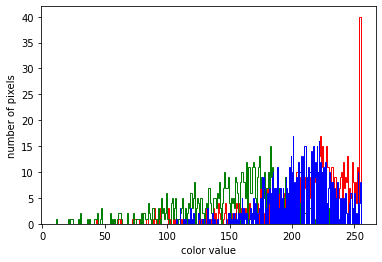

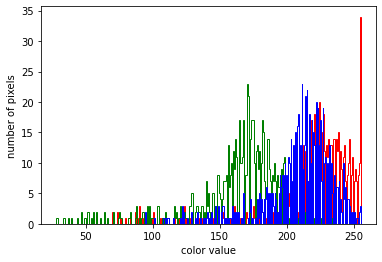

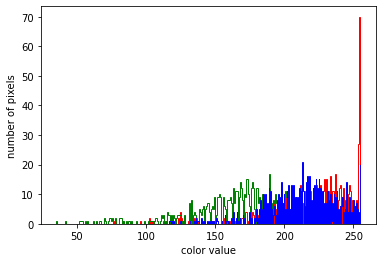

In [183]:
from skimage import io
def display_multiple_img_distribution(images_paths):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    for ind,image_path in enumerate(images_paths):
        image = io.imread(image_path)
        plt.figure()
        plt.hist(image[:, :, 0].flatten(), bins = 256, color = 'r', histtype = 'step')
        plt.hist(image[:, :, 1].flatten(), bins = 256, color = 'g', histtype = 'step')
        plt.hist(image[:, :, 2].flatten(), bins = 256, color = 'b', histtype = 'step')
        plt.xlabel('color value')
        plt.ylabel('number of pixels')
        plt.show()      
display_multiple_img_distribution(filePath[100:150])        

### Edge detection
https://www3.tuhh.de/sts/hoou/data-quality-explored/2-2-2-edge.html

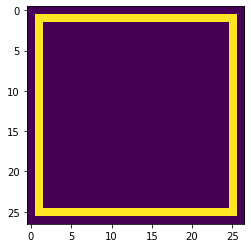

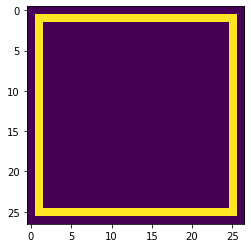

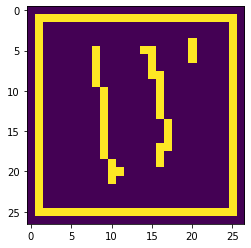

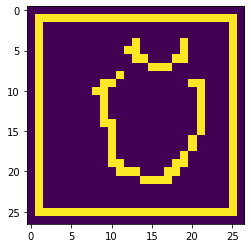

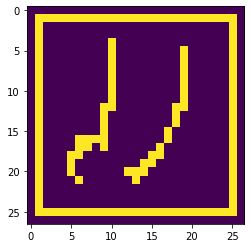

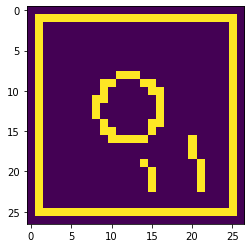

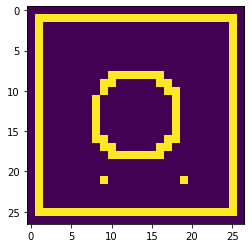

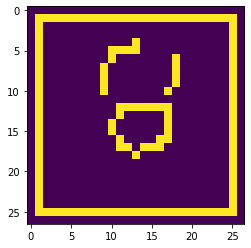

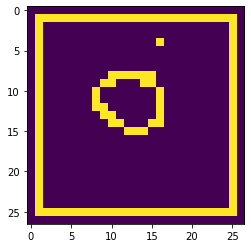

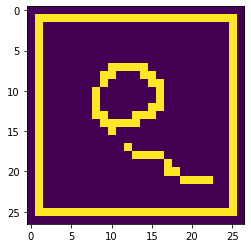

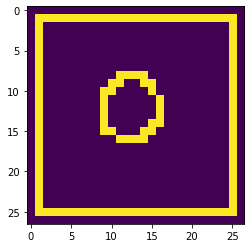

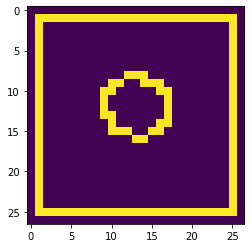

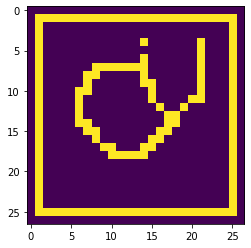

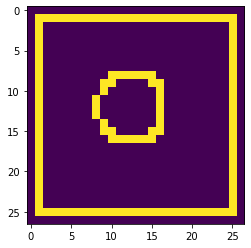

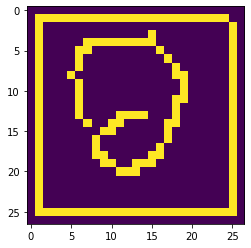

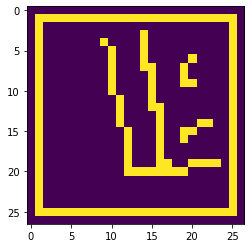

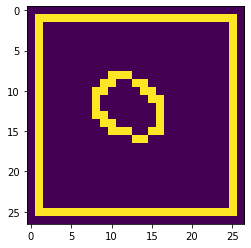

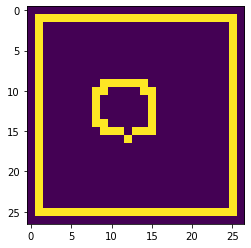

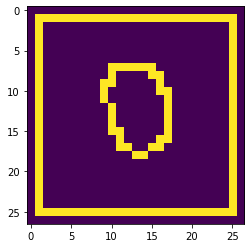

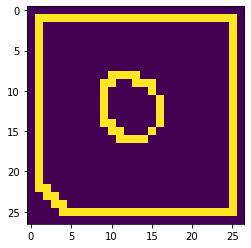

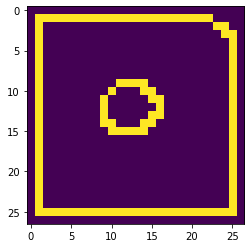

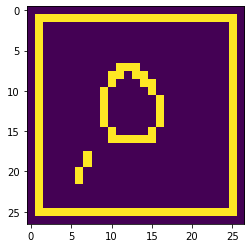

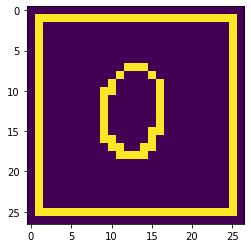

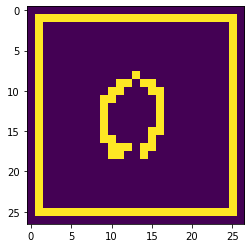

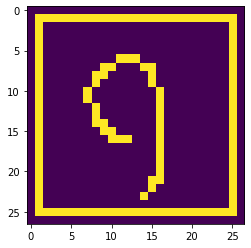

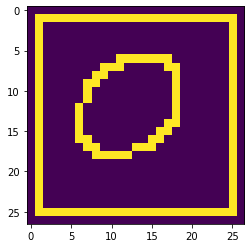

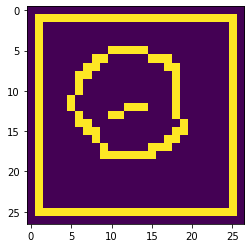

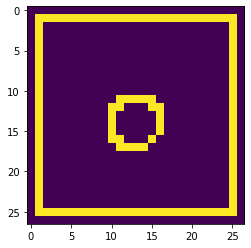

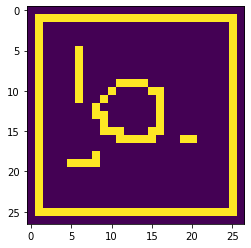

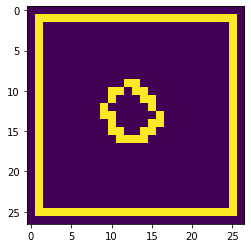

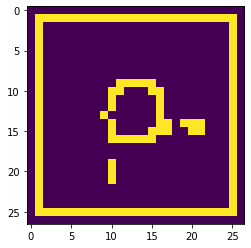

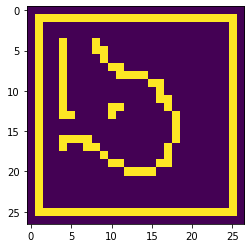

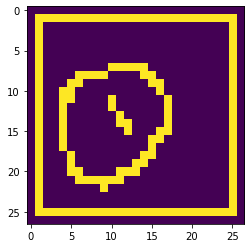

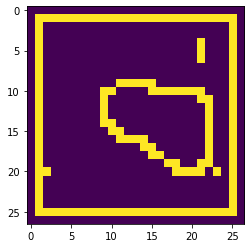

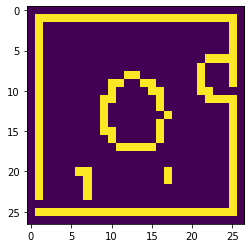

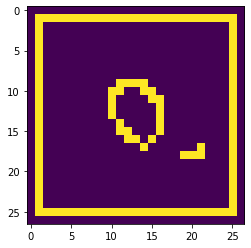

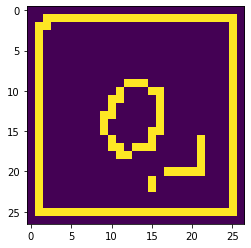

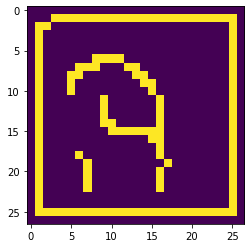

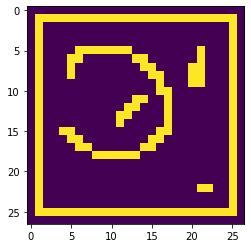

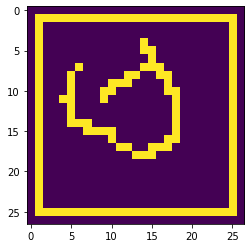

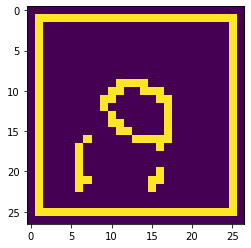

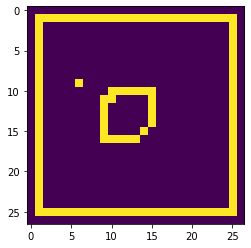

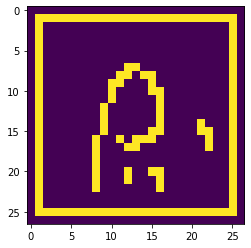

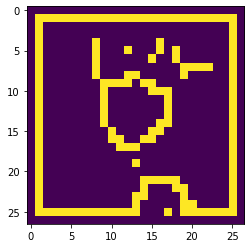

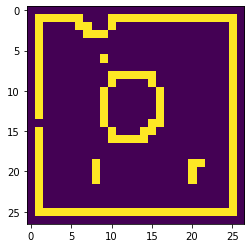

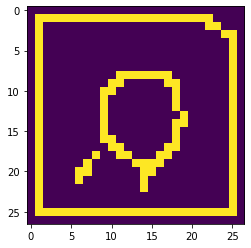

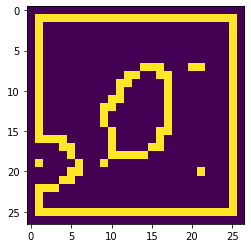

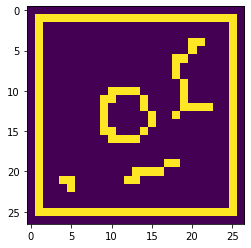

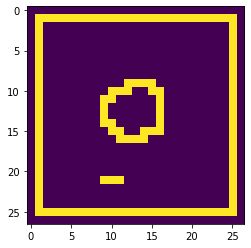

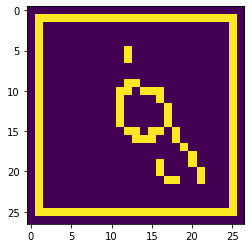

In [184]:
from skimage.color import rgb2gray
import skimage.feature as sf
def display_multiple_img_edge(images_paths):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    for ind,image_path in enumerate(images_paths):
        image = rgb2gray(io.imread(image_path))
        plt.imshow(image, cmap = 'gray')
        canny = sf.canny(image, sigma = 2)
        plt.imshow(canny)     
        plt.show()      
display_multiple_img_edge(filePath[100:150]) 

The contrast analysis through grayscale values can be confirmed with the use of edge detection methods. It is a tool for detecting the edges of things in a photograph and can be useful for tasks such as object detection or recognition without going into specifics about the technique itself.

Here, we can see that the image's quality may be estimated. But to be sure that it will enrich our own model, we need to apply our procedure (HOG descriptors) on the generated image. Using the previous graphs, we can see that HOG descriptors of the edge-detected image are better able to identify the cell type than the original image. The classification task can now be launched to see if it has any effect on the algorithm itself. To begin, we use the previously defined functions to create a model and make predictions based on the original image. In the next step, we convert the images into their canny equivalent and use the HOG features for the prediction..

Reference: Www3 tuhh de. 2022. Edge detection — Data Quality Explored, viewed <https://www3.tuhh.de/sts/hoou/data-quality-explored/2-2-2-edge.html >  

Kumari, S 2021, ‘Edge detection’, Mechmotive, 20 November, viewed 5 May 2022, <https://mechomotive.com/edge-detection/ >.

<h1> Preprocessing </h1>

In [185]:
data_extra

,InstanceID,patientID,ImageName,isCancerous,filePath
0,12681,61,12681.png,0,Image_classification_data/patch_images/12681.png
1,12682,61,12682.png,0,Image_classification_data/patch_images/12682.png
2,12683,61,12683.png,0,Image_classification_data/patch_images/12683.png
3,12684,61,12684.png,0,Image_classification_data/patch_images/12684.png
4,12685,61,12685.png,0,Image_classification_data/patch_images/12685.png
...,...,...,...,...,...
10379,20028,99,20028.png,0,Image_classification_data/patch_images/20028.png
10380,20029,99,20029.png,0,Image_classification_data/patch_images/20029.png
10381,20030,99,20030.png,0,Image_classification_data/patch_images/20030.png
10382,20031,99,20031.png,0,Image_classification_data/patch_images/20031.png


In [316]:
#!pip install keras 
from tensorflow.keras.preprocessing import image
def load_data(dataset): 

    data_dir_list = dataset['filePath']

    # data_dir_list = sorted_alphanumeric(os.listdir(data_path))
    img_data_list = []
    index = 0
    # maindata['image'] = maindata['ImageName'].map(lambda x: np.asarray(Image.open(x).resize(27,27)))



    for path in data_dir_list:
        img = image.load_img(path, target_size=(27,27))
        x = image.img_to_array(img)
        img_data_list.append(x)

    dataset["image"] = img_data_list


    return dataset
data_main = load_data(data_main)
data_extra = load_data(data_extra)
data_combine = pd.concat([data_main, data_extra], ignore_index=True)

In [317]:
def target_and_y(data, target):
    X = data['image']
    y = data[target]
    return X, y

In [318]:
# Explain why we combine two dataset here
X_combine, y_combine = target_and_y(data_combine, 'isCancerous')

In [319]:
data_combine.shape

(20280, 8)

In [320]:
data_combine.head() # convert file path

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,filePath,image
0,22405,1,22405.png,fibroblast,0.0,0,Image_classification_data/patch_images/22405.png,"[[[242.0, 213.0, 237.0], [239.0, 209.0, 233.0]..."
1,22406,1,22406.png,fibroblast,0.0,0,Image_classification_data/patch_images/22406.png,"[[[221.0, 175.0, 211.0], [224.0, 175.0, 211.0]..."
2,22407,1,22407.png,fibroblast,0.0,0,Image_classification_data/patch_images/22407.png,"[[[247.0, 243.0, 247.0], [248.0, 242.0, 246.0]..."
3,22408,1,22408.png,fibroblast,0.0,0,Image_classification_data/patch_images/22408.png,"[[[243.0, 242.0, 242.0], [243.0, 241.0, 241.0]..."
4,22409,1,22409.png,fibroblast,0.0,0,Image_classification_data/patch_images/22409.png,"[[[189.0, 130.0, 189.0], [186.0, 126.0, 184.0]..."


<h2> Image Flattening </h2>
https://www.geeksforgeeks.org/impact-of-image-flattening/

Flattening is a technique for converting multi-dimensional arrays into a 1-dimensional array. It is commonly used in Deep Learning while feeding the 1-D array information to the classification model.

One of the most important reasons why we flatten the Image Array before processing is because multidimensional arrays require more memory than 1-dimensional arrays. Flattening helps to reduce the amount of memory and time needed to train the model in most circumstances because we are dealing with a big number of photos.

The memory utilized by the multi-dimensional image array and the flattened array is nearly identical once the algorithm has been run in its entirety. So, why bother doing the flattening if it has no effect at all? As the number of photos in a dataset grows, so does the amount of memory that can be saved by eliminating them.

Reference: GeeksforGeeks, 2022, Impact of Image Flattening - GeeksforGeeks,viewed at 12 May 2022 <https://www.geeksforgeeks.org/impact-of-image-flattening/> 

In [322]:
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img)
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

bombus_features = create_features(X_combine[0])

print("Image shape before flatten: ", X_combine[0].shape )
print("Image shape after flatten: ", bombus_features.shape )

Image shape before flatten:  (27, 27, 3)
Image shape after flatten:  (2187,)


In [324]:
def convert3Dto2D(X):
    X_combine_2D = []
    #convert X to 2D array 
    for i in range(0,len(X)):
        X_combine_2D.append(X[i].flatten())
    return np.array(X_combine_2D)

<h2> PCA </h2>

PCA is a technique for transforming a dataset's columns into new features known as Principal Components. As a result, a significant amount of data from the entire dataset can be condensed into fewer feature columns. This allows for dimensionality reduction and the visualization of the separation of classes or clusters if any are present.

Using it, the dataset's feature redundancy can be eliminated. Also, it seeks to gather vital information that explains the high variance, which results in the best accuracy. It simplifies the process of working with data visualizations. By doing so, the model's complexity is reduced, but its computing efficiency is improved.

Reference: Prabhakaran, S 2019, ‘Principal Component Analysis (PCA) – Better Explained’, Machine Learning Plus, 23 March, viewed 5 May 2022, <https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/ >.

In [193]:
from sklearn.decomposition import PCA
def pca(X):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    return principalComponents

## Scatter the distributed

In [194]:
# Explain why we combine two dataset here

def convert_frame(X,y):
    frame = {}
    if X.shape[1]:
         frame = { '1': X[:, 0], '2': X[:, 1], '3' : y }  
    return pd.DataFrame(frame)
def scatter(X,y, type_):
    r = np.exp(-(X ** 2).sum(1))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    plt.show()
    
    result = convert_frame(X,y)
    
    #plot every type of y
    for i in range(0, len(y.value_counts())):
        print("Data distributed of" , type_, " = ", i)
        f =result[result['3'] ==i]
        plt.scatter(f['1'], f['2'], c=f['3'], s=30) 
        plt.show()
        
        r = np.exp(-(f[['1','2']] ** 2).sum(1))
        from mpl_toolkits import mplot3d
        ax = plt.subplot(projection='3d')
        ax.scatter3D(f['1'], f['2'],r, c=f['3'], s=30)
        plt.show()
    
   

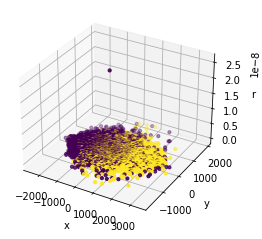

Data distributed of isCancerous  =  0


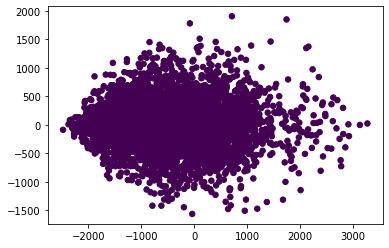

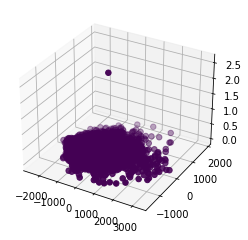

Data distributed of isCancerous  =  1


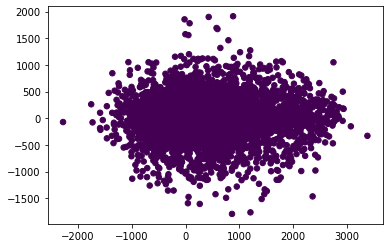

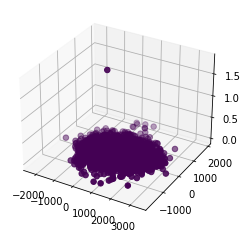

In [195]:
# Canncerous dataset main
X_combine, y_combine = target_and_y(data_main, 'isCancerous')
X_combine_2D = convert3Dto2D(X_combine)
X_combine_2D_pca = pca(X_combine_2D)
# combine_X_over, combine_y_over = smote(X_combine_2D_pca, y_combine)


scatter(X_combine_2D_pca,y_combine, "isCancerous")



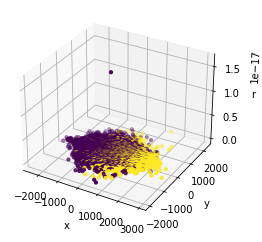

Data distributed of isCancerous  =  0


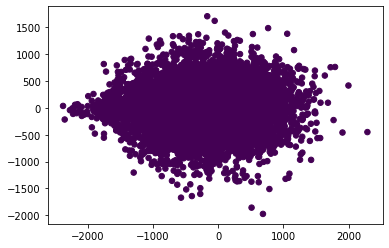

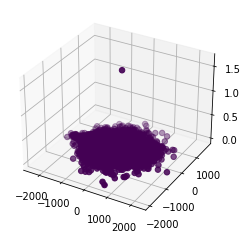

Data distributed of isCancerous  =  1


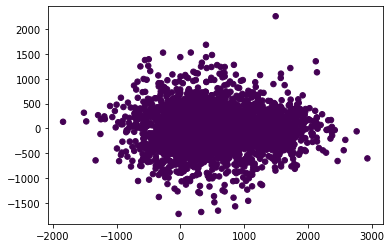

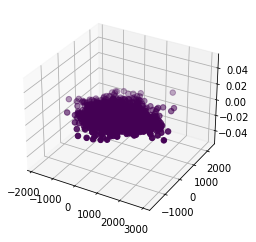

In [196]:
# Canncerous dataset extra
X_combine, y_combine = target_and_y(data_extra, 'isCancerous')
X_combine_2D = convert3Dto2D(X_combine)
X_combine_2D_pca = pca(X_combine_2D)
# combine_X_over, combine_y_over = smote(X_combine_2D_pca, y_combine)


scatter(X_combine_2D_pca,y_combine, "isCancerous")

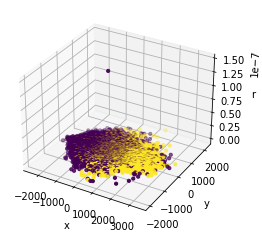

Data distributed of isCancerous  =  0


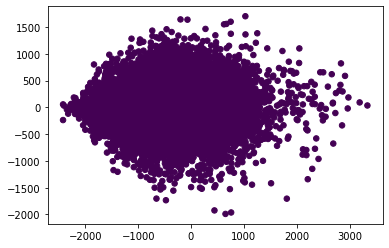

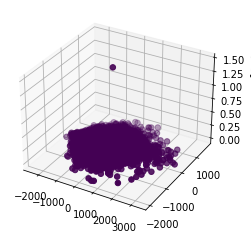

Data distributed of isCancerous  =  1


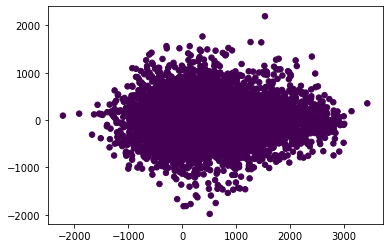

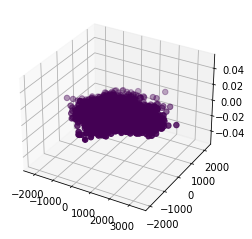

In [197]:
# Canncerous dataset main
X_combine, y_combine = target_and_y(data_combine, 'isCancerous')
X_combine_2D = convert3Dto2D(X_combine)
X_combine_2D_pca = pca(X_combine_2D)
# combine_X_over, combine_y_over = smote(X_combine_2D_pca, y_combine)


scatter(X_combine_2D_pca,y_combine, "isCancerous")

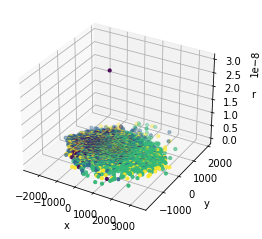

Data distributed of cellType  =  0


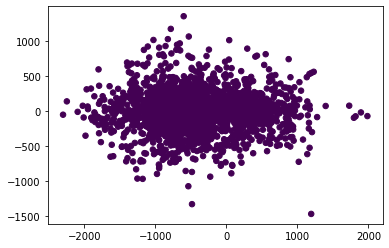

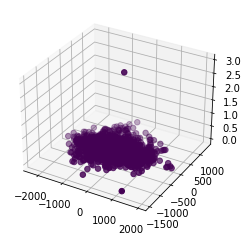

Data distributed of cellType  =  1


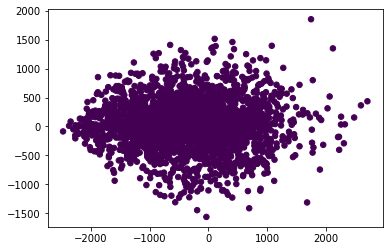

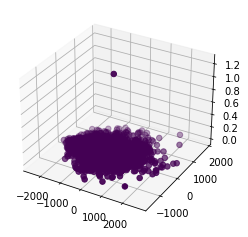

Data distributed of cellType  =  2


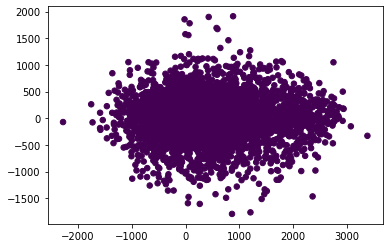

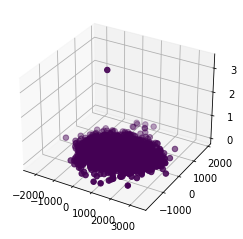

Data distributed of cellType  =  3


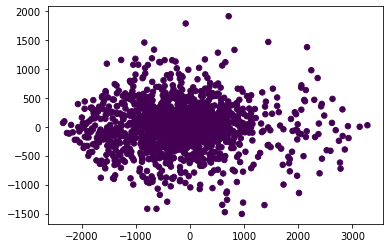

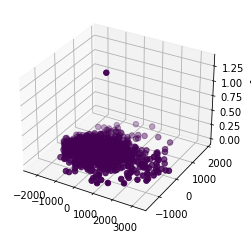

In [198]:
# CellType dataset
X_cell, y_cell = target_and_y(data_main, 'cellType')
X_cell_2D = convert3Dto2D(X_cell)
X_cell_2D_pca = pca(X_cell_2D)
# smote = SMOTE(sampling_strategy= {0 :4079,1:4079,2:4079,3:4079}) 
# cellmain_X_over,cellmain_y_over = smote.fit_resample(X_cell_2D_pca,y_cell)


scatter(X_cell_2D_pca,y_cell, "cellType")

<h2> Data Augmentation applying SMOTE </h2>

 Unbalance can be corrected with oversampling using SMOTE (synthetic minority oversampling technique). Randomly expanding minority class samples by copying them is the goal of this method. To create new minority cases, SMOTE blends together existing minority cases. Linear interpolation is used to create the virtual training records for the minority class. Each example in the minority class has a random selection of one or more of its k-nearest neighbors to create these synthetic training records. Several categorization models can be applied to the processed data after the oversampling procedure. 
 
 The following is how the SMOTE algorithm operates:
Draw a random sample from the minority group. K nearest neighbors will be identified from this sample.Once you've chosen a neighbor, you'll need to figure out the direction of travel between the current data point and that neighbor. The vector is multiplied by a number between 0 and 1, and the result is the new vector. For the synthetic data point, you add this to the current data point. This is essentially the same as moving a data point in the direction of a neighboring data point. Your synthetic data point will not be a perfect clone of a known data point, but it will also not be too distinct from known observations in your minority group.
 
 In task 1 we need to classify cell images to figure out if the patient is cancerous or not. Moreover, we do not apply the data augmentation to increase the number of images in a dataset because the quantity of the data is enough (20280 images for training and validation). Therefore, smote is applied due to the imbalance problem between the cancerous and not cancerous class.
 
 Reference: GeeksforGeeks 2021, ‘ML | Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python’, GeeksforGeeks, 13 December, viewed 2 May 2022, <https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/?fbclid=IwAR3nbCrsVGzTtSbzj6OZifeMa2CY-fDR7SXad6iLxmRkzDndVr_A8bR9MMc#:~:text=SMOTE%20(synthetic%20minority%20oversampling%20technique)%20is%20one%20of%20the%20most,instances%20between%20existing%20minority%20instances>
 
Korstanje, J 2021, ‘SMOTE’, Towards Data Science, 30 August, viewed 5 May 2022, <https://towardsdatascience.com/smote-fdce2f605729?gi=fc9f18d467d>

In [199]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
def smote(X, y):
    over = SMOTE(sampling_strategy=1) 
    X_over,y_over = over.fit_resample(X,y)
    return X_over, y_over

## Normalization

In [325]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_combine_2D)
X_normalize = scaling.transform(X_combine_2D)

## Test plit

In [326]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_normalize,y_combine,test_size=0.20,random_state=77,stratify=y_combine)
print('Splitted Successfully')

Splitted Successfully


## Visualize output

In [202]:
def visualize_confusion(cm):
  labels = ['TN', 'FP','FN','TP']
  label_count = ["{0:0.0f}".format(value) for value
                in cm.flatten()]
  labels = [f"{label}\n{count}" for label, count
            in zip(labels, label_count)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm, annot= labels, fmt = '', cmap='Blues')

In [227]:
#initialize dataframe to store the model results.
testPerformance = pd.DataFrame(columns = ['Algorithm','F1','Recall', 'Precision', 'Accuracy' ])

In [204]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
#Validate function
def validate(model, x_test, y_test, model_name):
    global testPerformance
    y_pred =model.predict(x_test)
   
    
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print("Information on data is",classification_report(y_test,y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    visualize_confusion(conf_matrix)
    testPerformance= testPerformance.append({'Algorithm' : model_name,'F1': f1,'Recall' : recall ,'Precision': precision, 'Accuracy': accuracy },ignore_index=True)

## Modeling
<h2> 1. SVM Model </h2>

Information on data is               precision    recall  f1-score   support

           0       0.91      0.93      0.92      2642
           1       0.86      0.83      0.84      1414

    accuracy                           0.89      4056
   macro avg       0.88      0.88      0.88      4056
weighted avg       0.89      0.89      0.89      4056



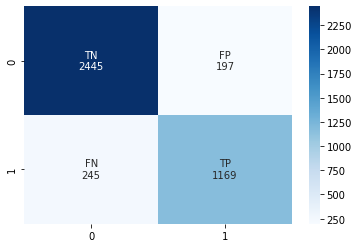

In [229]:
from sklearn.svm import SVC
#base model
svc = SVC()
svc.fit(x_train, y_train)

validate(svc, x_test, y_test, "SVC base")

<h3> 1.2 Applying SMOTE </h3>

In [230]:
y_train.value_counts()

0    10569
1     5655
Name: isCancerous, dtype: int64

In [231]:
x_train_over, y_train_over = smote(x_train, y_train)
y_train_over.value_counts()

0    10569
1    10569
Name: isCancerous, dtype: int64

Information on data is               precision    recall  f1-score   support

           0       0.92      0.91      0.91      2642
           1       0.83      0.85      0.84      1414

    accuracy                           0.89      4056
   macro avg       0.88      0.88      0.88      4056
weighted avg       0.89      0.89      0.89      4056



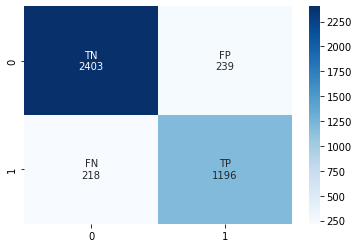

In [232]:
# base model on SMOTE balance dataset
svc_smote = SVC()
svc_smote.fit(x_train_over, y_train_over)

validate(svc_smote, x_test, y_test, "SVC base with SMOTE")

In [233]:
testPerformance

,Algorithm,F1,Recall,Precision,Accuracy
0,SVC base,0.841007,0.826733,0.855783,0.891026
1,SVC base with SMOTE,0.839593,0.845827,0.833449,0.887327


As we see after appyling SMOTE with the base model SVM the F1 score increases a little bit and also the Recall score in 0.205 (considering). However the Precision drop about 0.2, and also a littble bit drop in Accuracy. It means that we trade off about the precision and recall. Indeed, it's more important to not missing out which cell is Cancerous than incorrectly define a cell which is not cancerous to be cancerous. Therefore, we need to care much more about the recall score, therefore it's better to choose SVC with SMOTE technique here.  <br>
But we also need to find way to optimize the model.



<h3> 1.3 OPTIMIZATION APPLYING GRID SEARCH </h3>

In [210]:
#grid_svc 
grid_svc = {
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'C' : [ 10, 1.0, 0.1, 100,1000],
    'gamma' : ['scale']
}

In [216]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svm_model_grid= SVC()

svm_model_grid = GridSearchCV(svm_model_grid, grid_svc,cv=3,scoring='f1')

svm_model_grid.fit(x_train, y_train)
print(svm_model_grid.best_score_)

0.8313538232973979


In [217]:
print(svm_model_grid.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Information on data is               precision    recall  f1-score   support

           0       0.91      0.92      0.91      2642
           1       0.84      0.83      0.83      1414

    accuracy                           0.89      4056
   macro avg       0.88      0.87      0.87      4056
weighted avg       0.89      0.89      0.89      4056



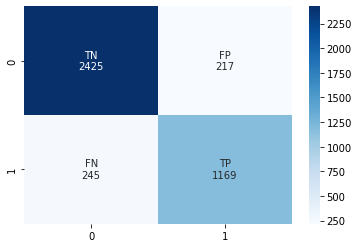

In [234]:
validate(svm_model_grid, x_test, y_test, "SVC Grid with SMOTE")

Information on data is               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2642
           1       0.88      0.76      0.82      1414

    accuracy                           0.88      4056
   macro avg       0.88      0.85      0.86      4056
weighted avg       0.88      0.88      0.88      4056



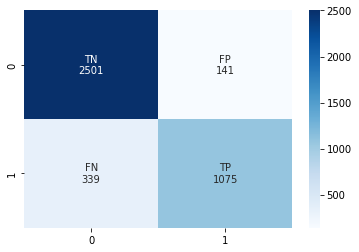

In [220]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=0.01, C = 10 )
svc.fit(x_train_over, y_train_over)
validate(svc, x_test, y_test, "SVC Grid with SMOTE & Gamma Optimizer")


Information on data is               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2642
           1       0.88      0.76      0.82      1414

    accuracy                           0.88      4056
   macro avg       0.88      0.85      0.87      4056
weighted avg       0.88      0.88      0.88      4056



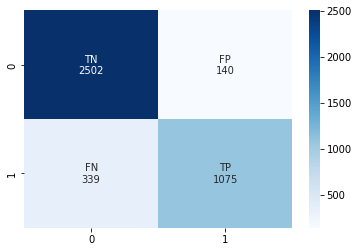

In [235]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=0.01, C = 10 )
svc.fit(x_train, y_train)
validate(svc, x_test, y_test, "SVC Grid with Gamma Optimizer")

In [236]:
testPerformance

,Algorithm,F1,Recall,Precision,Accuracy
0,SVC base,0.841007,0.826733,0.855783,0.891026
1,SVC base with SMOTE,0.839593,0.845827,0.833449,0.887327
2,SVC Grid with SMOTE,0.835000,0.826733,0.843434,0.886095
3,SVC Grid with Gamma Optimizer,0.817801,0.760255,0.884774,0.881903


After all step we can see that applying Grid increases the Precision score but in our prioritize is F1 score and recall score therefore, the final SVM model we choose is SVC base one with SMOTE.

# 1.4 CNN model


Create a create model function that take in learn rate and epsilon:
For the model:
The first layer that we use is a 2-dimensional convolutional layer. In addition to that, we have some parameters for that layer and an additional neural network layer which is Batch Normalization layer. The first parameter that we used for this layer is the filter = 32 which means that we are not looking for feature that are not too detailed. The next parameter is the kernel size and we put it = (3, 3) which mean we are looking for the feature in a 3x3 kernel and it will be apply throughout the image. We also apply “relu” activation function so that the new layer does not have negative value. Moreover, we have the padding = “same” so that the output will be the same as the imput H x W. Since this is the first layer, we have to specify the input shape to be equal to our input which is (27, 27, 3). Finally, we add a Batch Normalization layer to make sure that all the features are on the same scale since each one is different. This layer output a layer with shape (27, 27, 32). The second layer is the same as the first layer but as it no longer has the padding attribute, this layer has one less data on each side which makes this layer output a layer with shape (25, 25, 32). Next is the 2 dimensional Maxpool which is taking the maximum number from a fixed shape as the data for the layer. The pool size parameter of this layer means that the layer will take the maximum number from a 2x2 square of the input layer and put it as a data for the maxpool layer. That is why the output of this layer is a (12, 12, 32). 

The next 3 layers is the same as the first layer but the only difference is that the input of the first three layer is has the shape of (27, 27, 3) and output has the shape of (12, 12, 32) while the next 3 layers has the input = (12, 12, 32) and output = (5, 5, 64) which means it has map out the feature much clearer than the first 3 layers.

After that, we flatten the output so that it turns into a 1 dimensional array. This array has 1600 data which is = 5*5*64

The next layer is the dense layer which is a layer that contain 128 variation of image that 1600 image data can be classified into. This is the layer where we look into all the image and classify them into all the variation and categorize them. After that, we normalize them and use the Dropout technique. Dropout technique is not using all the data for the next step and in this case is 20%. we do not use 20% since not all variation putting into our model will be helpful so we will only take 80% out of all the variation. The next layer is the same as the former layer. The reason why we have more dense layer is to disregard the special feature and highlight the common feature.

Finally, we have the final dense layer which have the activation function = softmax which is used to categorize into what type of category this image is most likely to be based on how similar it is to the original one.
For the optimizer, we use Adam with the parameter that we defined at the beginning.
We get the result for each epoch and parameter.
We also defined some functions that we will be using later on.

In [60]:
def get_pseudo_label(predictions):
    result = []
    
    for data in predictions:
        max_value = np.max(data)
        data = np.where(data == max_value, 1, 0)
        result.append(data)
    result = np.array(result)
    return result;
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def create_model(learn_rate=0.001, epsilon = None):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    optimizer = optimizers.Adam(learning_rate= learn_rate, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=1.0e-6,amsgrad=False)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=[f1])
    print("epsilon = ", epsilon, ", learning_rate = ", learn_rate)
    return model
def validate_CNN(y_test, y_pred_raw, model_name):
    global testPerformance
    y_pred = get_pseudo_label(y_pred_raw)
    y_pred = y_pred.argmax(axis=1)
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    print("Information on data is",classification_report(y_test,y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    visualize_confusion(conf_matrix)
    testPerformance= testPerformance.append({'Algorithm' : model_name,'F1': f1,'Recall' : recall ,'Precision': precision, 'Accuracy': accuracy },ignore_index=True)

change y_train format using to_categorical so that the CNN can use it to predict

In [61]:
x_train_CNN = np.reshape(x_train, (x_train.shape[0], 27, 27, 3))
x_test_CNN = np.reshape(x_test, (x_test.shape[0], 27, 27, 3))
y_train_CNN = to_categorical(y_train, num_classes = 2)
y_test_CNN = to_categorical(y_test, num_classes = 2)

epsilon =  1e-07 , learning_rate =  0.001
Epoch 1/30
208/208 [==============================] - 29s 132ms/step - loss: 0.3579 - f1: 0.8558 - val_loss: 0.5952 - val_f1: 0.6839 - lr: 0.0010
Epoch 2/30
208/208 [==============================] - 28s 133ms/step - loss: 0.2645 - f1: 0.8916 - val_loss: 0.3827 - val_f1: 0.8215 - lr: 0.0010
Epoch 3/30
208/208 [==============================] - 29s 139ms/step - loss: 0.2313 - f1: 0.9080 - val_loss: 0.2890 - val_f1: 0.8836 - lr: 0.0010
Epoch 4/30
208/208 [==============================] - 30s 146ms/step - loss: 0.2087 - f1: 0.9170 - val_loss: 0.3684 - val_f1: 0.8698 - lr: 0.0010
Epoch 5/30
208/208 [==============================] - 30s 146ms/step - loss: 0.1973 - f1: 0.9199 - val_loss: 0.3712 - val_f1: 0.8797 - lr: 0.0010
Epoch 6/30
208/208 [==============================] - 31s 150ms/step - loss: 0.1734 - f1: 0.9315 - val_loss: 0.3025 - val_f1: 0.8782 - lr: 0.0010
Epoch 7/30
208/208 [==============================] - 30s 146ms/step - loss: 0.149

C:\Users\Asus\AppData\Local\Temp\ipykernel_4148\1393569930.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  testPerformance= testPerformance.append({'Algorithm' : model_name,'F1': f1,'Recall' : recall ,'Precision': precision, 'Accuracy': accuracy },ignore_index=True)


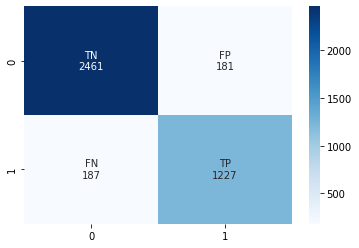

In [69]:
basic_CNN_model = create_model(0.001, 1.0e-7)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
batch_size = 78
epochs = 30
history = basic_CNN_model.fit(x_train_CNN, y_train_CNN,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test_CNN, y_test_CNN),
        shuffle=True, callbacks=[lr_reducer])
y_pred = basic_CNN_model.predict(x_test_CNN)
validate_CNN(y_test_CNN.argmax(axis=1), y_pred, "CNN")

# 1.5 CNN model with SMOTE


In [70]:
x_train_CNN_over = np.reshape(x_train_over, (x_train_over.shape[0], 27, 27, 3))
y_train_CNN_over = to_categorical(y_train_over, num_classes = 2)

epsilon =  1e-07 , learning_rate =  0.001
Epoch 1/30
271/271 [==============================] - 49s 177ms/step - loss: 0.3042 - f1: 0.8767 - val_loss: 4.1853 - val_f1: 0.3486 - lr: 0.0010
Epoch 2/30
271/271 [==============================] - 46s 171ms/step - loss: 0.2280 - f1: 0.9090 - val_loss: 0.3167 - val_f1: 0.8693 - lr: 0.0010
Epoch 3/30
271/271 [==============================] - 47s 174ms/step - loss: 0.1946 - f1: 0.9227 - val_loss: 0.2439 - val_f1: 0.9004 - lr: 0.0010
Epoch 4/30
271/271 [==============================] - 49s 180ms/step - loss: 0.1701 - f1: 0.9332 - val_loss: 0.3624 - val_f1: 0.8607 - lr: 0.0010
Epoch 5/30
271/271 [==============================] - 49s 181ms/step - loss: 0.1527 - f1: 0.9418 - val_loss: 0.9163 - val_f1: 0.7894 - lr: 0.0010
Epoch 6/30
271/271 [==============================] - 50s 184ms/step - loss: 0.1289 - f1: 0.9512 - val_loss: 0.2782 - val_f1: 0.9001 - lr: 0.0010
Epoch 7/30
271/271 [==============================] - 47s 175ms/step - loss: 0.112

C:\Users\Asus\AppData\Local\Temp\ipykernel_4148\1393569930.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  testPerformance= testPerformance.append({'Algorithm' : model_name,'F1': f1,'Recall' : recall ,'Precision': precision, 'Accuracy': accuracy },ignore_index=True)


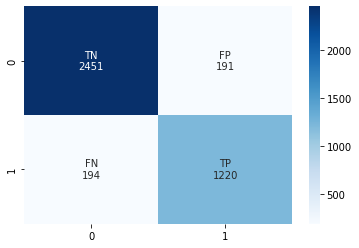

In [71]:
CNN_model_with_SMOTE = create_model(0.001, 1.0e-7)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
batch_size = 78
epochs = 30
history = CNN_model_with_SMOTE.fit(x_train_CNN_over, y_train_CNN_over,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test_CNN, y_test_CNN),
        shuffle=True, callbacks=[lr_reducer])
y_pred = CNN_model_with_SMOTE.predict(x_test_CNN)
validate_CNN(y_test_CNN.argmax(axis=1), y_pred, "CNN model with smote")

# 1.6 CNN model with SMOTE and optimizer applying gridsearch


In [75]:
from keras.wrappers.scikit_learn import KerasClassifier
grid_search = {
    'learn_rate' : [0.00001, 0.00005, 0.0001],
    'epsilon' : [1.0e-7 , 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2],
}
testmodel = KerasClassifier(build_fn=create_model, epochs=10, batch_size=75, verbose=1)
grid_search = GridSearchCV(estimator=testmodel, param_grid=grid_search, n_jobs=1)
grid_result = grid_search.fit(np.asarray(x_train_CNN_over[:5000]), np.asarray(y_train_CNN_over[:5000]))


epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10


C:\Users\Asus\AppData\Local\Temp\ipykernel_4148\4275227761.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  testmodel = KerasClassifier(build_fn=create_model, epochs=10, batch_size=75, verbose=1)


54/54 [==============================] - 8s 125ms/step - loss: 1.0473 - f1: 0.5096
Epoch 2/10
54/54 [==============================] - 6s 120ms/step - loss: 0.7997 - f1: 0.6232
Epoch 3/10
54/54 [==============================] - 7s 129ms/step - loss: 0.6905 - f1: 0.6837
Epoch 4/10
54/54 [==============================] - 7s 121ms/step - loss: 0.6210 - f1: 0.7249
Epoch 5/10
54/54 [==============================] - 8s 140ms/step - loss: 0.5867 - f1: 0.7383
Epoch 6/10
54/54 [==============================] - 7s 122ms/step - loss: 0.5623 - f1: 0.7551
Epoch 7/10
54/54 [==============================] - 8s 155ms/step - loss: 0.5284 - f1: 0.7696
Epoch 8/10
54/54 [==============================] - 9s 162ms/step - loss: 0.4937 - f1: 0.7832
Epoch 9/10
54/54 [==============================] - 9s 159ms/step - loss: 0.5095 - f1: 0.7812
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.4509 - f1: 0.8038


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 0.9800 - f1: 0.5657
Epoch 2/10
54/54 [==============================] - 8s 144ms/step - loss: 0.8091 - f1: 0.6351
Epoch 3/10
54/54 [==============================] - 8s 143ms/step - loss: 0.6901 - f1: 0.6921
Epoch 4/10
54/54 [==============================] - 8s 139ms/step - loss: 0.6322 - f1: 0.7153
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5879 - f1: 0.7496
Epoch 6/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5677 - f1: 0.7598
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5234 - f1: 0.7719
Epoch 8/10
54/54 [==============================] - 8s 147ms/step - loss: 0.5151 - f1: 0.7872
Epoch 9/10
54/54 [==============================] - 8s 148ms/step - loss: 0.4936 - f1: 0.7953
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.5325 - f1: 0.7771


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 136ms/step - loss: 0.9503 - f1: 0.5400
Epoch 2/10
54/54 [==============================] - 8s 139ms/step - loss: 0.7723 - f1: 0.6314
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.6818 - f1: 0.6773
Epoch 4/10
54/54 [==============================] - 9s 159ms/step - loss: 0.6289 - f1: 0.7188
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.6007 - f1: 0.7336
Epoch 6/10
54/54 [==============================] - 8s 139ms/step - loss: 0.5553 - f1: 0.7560
Epoch 7/10
54/54 [==============================] - 8s 147ms/step - loss: 0.5359 - f1: 0.7644
Epoch 8/10
54/54 [==============================] - 8s 151ms/step - loss: 0.5136 - f1: 0.7751
Epoch 9/10
54/54 [==============================] - 8s 150ms/step - loss: 0.5017 - f1: 0.7849
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.5023 - f1: 0.7905


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 146ms/step - loss: 0.9088 - f1: 0.5926
Epoch 2/10
54/54 [==============================] - 8s 139ms/step - loss: 0.7607 - f1: 0.6605
Epoch 3/10
54/54 [==============================] - 7s 134ms/step - loss: 0.6943 - f1: 0.6884
Epoch 4/10
54/54 [==============================] - 8s 145ms/step - loss: 0.6355 - f1: 0.7202
Epoch 5/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5952 - f1: 0.7474
Epoch 6/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5701 - f1: 0.7531
Epoch 7/10
54/54 [==============================] - 8s 149ms/step - loss: 0.5301 - f1: 0.7640
Epoch 8/10
54/54 [==============================] - 8s 145ms/step - loss: 0.5182 - f1: 0.7760
Epoch 9/10
54/54 [==============================] - 8s 143ms/step - loss: 0.4862 - f1: 0.7933
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.6370 - f1: 0.7305


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 10s 170ms/step - loss: 0.9039 - f1: 0.5822
Epoch 2/10
54/54 [==============================] - 11s 195ms/step - loss: 0.7239 - f1: 0.6741
Epoch 3/10
54/54 [==============================] - 8s 149ms/step - loss: 0.6490 - f1: 0.7086
Epoch 4/10
54/54 [==============================] - 8s 145ms/step - loss: 0.5954 - f1: 0.7281
Epoch 5/10
54/54 [==============================] - 9s 164ms/step - loss: 0.5573 - f1: 0.7590
Epoch 6/10
54/54 [==============================] - 10s 176ms/step - loss: 0.5307 - f1: 0.7746
Epoch 7/10
54/54 [==============================] - 9s 167ms/step - loss: 0.5058 - f1: 0.7820
Epoch 8/10
54/54 [==============================] - 10s 176ms/step - loss: 0.4838 - f1: 0.7965
Epoch 9/10
54/54 [==============================] - 8s 157ms/step - loss: 0.4692 - f1: 0.8040
Epoch 10/10
14/14 [==============================] - 1s 27ms/step - loss: 0.4786 - f1: 0.8029


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 140ms/step - loss: 0.8678 - f1: 0.6343
Epoch 2/10
54/54 [==============================] - 8s 142ms/step - loss: 0.5547 - f1: 0.7590
Epoch 3/10
54/54 [==============================] - 8s 146ms/step - loss: 0.4618 - f1: 0.8030
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.4143 - f1: 0.8309
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3526 - f1: 0.8558
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3041 - f1: 0.8728
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2751 - f1: 0.8904
Epoch 8/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2599 - f1: 0.8998
Epoch 9/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2280 - f1: 0.9121
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3660 - f1: 0.8676


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 8s 137ms/step - loss: 0.7316 - f1: 0.6612
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5283 - f1: 0.7635
Epoch 3/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4442 - f1: 0.8074
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3836 - f1: 0.8388
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.3593 - f1: 0.8474
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3198 - f1: 0.8726
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2951 - f1: 0.8785
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2646 - f1: 0.8973
Epoch 9/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2573 - f1: 0.9035
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3986 - f1: 0.8505
epsilon =  1e-07 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 139ms/step - loss: 0.7496 - f1: 0.6642
Epoch 2/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5299 - f1: 0.7795
Epoch 3/10
54/54 [==============================] - 8s 139ms/step - loss: 0.4394 - f1: 0.8128
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3775 - f1: 0.8457
Epoch 5/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3577 - f1: 0.8412
Epoch 6/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3068 - f1: 0.8760
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2737 - f1: 0.8916
Epoch 8/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2360 - f1: 0.9077
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2138 - f1: 0.9141
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3981 - f1: 0.8505
epsilon =  1e-07 , learning_rate =  5e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 11s 176ms/step - loss: 0.7836 - f1: 0.6560
Epoch 2/10
54/54 [==============================] - 9s 157ms/step - loss: 0.5176 - f1: 0.7723
Epoch 3/10
54/54 [==============================] - 8s 149ms/step - loss: 0.4239 - f1: 0.8193
Epoch 4/10
54/54 [==============================] - 8s 139ms/step - loss: 0.3753 - f1: 0.8427
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.3349 - f1: 0.8689
Epoch 6/10
54/54 [==============================] - 8s 145ms/step - loss: 0.3194 - f1: 0.8674
Epoch 7/10
54/54 [==============================] - 7s 134ms/step - loss: 0.2873 - f1: 0.8894
Epoch 8/10
54/54 [==============================] - 8s 145ms/step - loss: 0.2561 - f1: 0.8990
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2355 - f1: 0.9027
Epoch 10/10
14/14 [==============================] - 1s 34ms/step - loss: 0.4016 - f1: 0.8429


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 138ms/step - loss: 0.8143 - f1: 0.6635
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5437 - f1: 0.7825
Epoch 3/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4359 - f1: 0.8148
Epoch 4/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3914 - f1: 0.8437
Epoch 5/10
54/54 [==============================] - 8s 139ms/step - loss: 0.3398 - f1: 0.8677
Epoch 6/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3136 - f1: 0.8785
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2709 - f1: 0.8857
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2589 - f1: 0.9032
Epoch 9/10
54/54 [==============================] - 7s 137ms/step - loss: 0.2449 - f1: 0.9074
Epoch 10/10
14/14 [==============================] - 1s 27ms/step - loss: 0.3119 - f1: 0.8610


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 139ms/step - loss: 0.7077 - f1: 0.7123
Epoch 2/10
54/54 [==============================] - 7s 136ms/step - loss: 0.4618 - f1: 0.8101
Epoch 3/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3646 - f1: 0.8511
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2997 - f1: 0.8753
Epoch 5/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2557 - f1: 0.9025
Epoch 6/10
54/54 [==============================] - 8s 147ms/step - loss: 0.2204 - f1: 0.9099
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.1954 - f1: 0.9222
Epoch 8/10
54/54 [==============================] - 7s 134ms/step - loss: 0.1613 - f1: 0.9373
Epoch 9/10
54/54 [==============================] - 7s 136ms/step - loss: 0.1541 - f1: 0.9417
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.4411 - f1: 0.8419
epsilon =  1e-07 

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 142ms/step - loss: 0.7384 - f1: 0.6872
Epoch 2/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4521 - f1: 0.8086
Epoch 3/10
54/54 [==============================] - 8s 140ms/step - loss: 0.3553 - f1: 0.8570
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2883 - f1: 0.8822
Epoch 5/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2417 - f1: 0.9040
Epoch 6/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2096 - f1: 0.9232
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.1845 - f1: 0.9264
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.1630 - f1: 0.9373
Epoch 9/10
54/54 [==============================] - 8s 142ms/step - loss: 0.1395 - f1: 0.9514
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3237 - f1: 0.8705


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 147ms/step - loss: 0.7362 - f1: 0.6837
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.4526 - f1: 0.8020
Epoch 3/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3594 - f1: 0.8533
Epoch 4/10
54/54 [==============================] - 8s 147ms/step - loss: 0.2980 - f1: 0.8760
Epoch 5/10
54/54 [==============================] - 8s 139ms/step - loss: 0.2493 - f1: 0.8965
Epoch 6/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2004 - f1: 0.9205
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.1796 - f1: 0.9319
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.1424 - f1: 0.9509
Epoch 9/10
54/54 [==============================] - 9s 162ms/step - loss: 0.1354 - f1: 0.9491
Epoch 10/10
14/14 [==============================] - 1s 27ms/step - loss: 0.4070 - f1: 0.8562


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 156ms/step - loss: 0.7009 - f1: 0.6985
Epoch 2/10
54/54 [==============================] - 8s 157ms/step - loss: 0.4379 - f1: 0.8131
Epoch 3/10
54/54 [==============================] - 8s 151ms/step - loss: 0.3405 - f1: 0.8560
Epoch 4/10
54/54 [==============================] - 8s 153ms/step - loss: 0.2856 - f1: 0.8817
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2491 - f1: 0.9044
Epoch 6/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2093 - f1: 0.9220
Epoch 7/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1908 - f1: 0.9240
Epoch 8/10
54/54 [==============================] - 8s 141ms/step - loss: 0.1643 - f1: 0.9407
Epoch 9/10
54/54 [==============================] - 7s 135ms/step - loss: 0.1366 - f1: 0.9546
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4600 - f1: 0.8276


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-07 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 8s 136ms/step - loss: 0.6471 - f1: 0.7269
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.4237 - f1: 0.8259
Epoch 3/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3391 - f1: 0.8627
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3018 - f1: 0.8857
Epoch 5/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2407 - f1: 0.9049
Epoch 6/10
54/54 [==============================] - 7s 139ms/step - loss: 0.2231 - f1: 0.9146
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.1909 - f1: 0.9254
Epoch 8/10
54/54 [==============================] - 7s 135ms/step - loss: 0.1737 - f1: 0.9375
Epoch 9/10
54/54 [==============================] - 7s 138ms/step - loss: 0.1595 - f1: 0.9422
Epoch 10/10
14/14 [==============================] - 1s 38ms/step - loss: 0.3306 - f1: 0.8533


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 8s 137ms/step - loss: 1.0426 - f1: 0.5294
Epoch 2/10
54/54 [==============================] - 8s 150ms/step - loss: 0.8099 - f1: 0.6289
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.7142 - f1: 0.6879
Epoch 4/10
54/54 [==============================] - 7s 136ms/step - loss: 0.6427 - f1: 0.7141
Epoch 5/10
54/54 [==============================] - 8s 139ms/step - loss: 0.6042 - f1: 0.7435
Epoch 6/10
54/54 [==============================] - 7s 139ms/step - loss: 0.5849 - f1: 0.7388
Epoch 7/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5464 - f1: 0.7637
Epoch 8/10
54/54 [==============================] - 8s 139ms/step - loss: 0.5361 - f1: 0.7741
Epoch 9/10
54/54 [==============================] - 7s 139ms/step - loss: 0.5018 - f1: 0.7802
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.6164 - f1: 0.7352
epsilon =  1e-06 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 134ms/step - loss: 1.0451 - f1: 0.5165
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.8663 - f1: 0.5933
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.7395 - f1: 0.6635
Epoch 4/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6814 - f1: 0.6867
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6147 - f1: 0.7232
Epoch 6/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5681 - f1: 0.7467
Epoch 7/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5457 - f1: 0.7558
Epoch 8/10
54/54 [==============================] - 8s 145ms/step - loss: 0.5163 - f1: 0.7751
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4847 - f1: 0.7857
Epoch 10/10
14/14 [==============================] - 1s 35ms/step - loss: 0.5903 - f1: 0.7400


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 146ms/step - loss: 0.9422 - f1: 0.5704
Epoch 2/10
54/54 [==============================] - 8s 150ms/step - loss: 0.7878 - f1: 0.6467
Epoch 3/10
54/54 [==============================] - 9s 164ms/step - loss: 0.6907 - f1: 0.6844
Epoch 4/10
54/54 [==============================] - 9s 165ms/step - loss: 0.6387 - f1: 0.7074
Epoch 5/10
54/54 [==============================] - 8s 151ms/step - loss: 0.6185 - f1: 0.7240
Epoch 6/10
54/54 [==============================] - 8s 147ms/step - loss: 0.5701 - f1: 0.7437
Epoch 7/10
54/54 [==============================] - 8s 140ms/step - loss: 0.5528 - f1: 0.7417
Epoch 8/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5367 - f1: 0.7558
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.5054 - f1: 0.7798
Epoch 10/10
14/14 [==============================] - 1s 27ms/step - loss: 0.8360 - f1: 0.6581
epsilon =  1e-06 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 1.0040 - f1: 0.5538
Epoch 2/10
54/54 [==============================] - 8s 142ms/step - loss: 0.8376 - f1: 0.6242
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.7191 - f1: 0.6706
Epoch 4/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6529 - f1: 0.7123
Epoch 5/10
54/54 [==============================] - 7s 139ms/step - loss: 0.6109 - f1: 0.7309
Epoch 6/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5729 - f1: 0.7474
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.5381 - f1: 0.7632
Epoch 8/10
54/54 [==============================] - 7s 139ms/step - loss: 0.4980 - f1: 0.7807
Epoch 9/10
54/54 [==============================] - 8s 148ms/step - loss: 0.4790 - f1: 0.7901
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.6182 - f1: 0.7400


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 8s 138ms/step - loss: 0.9451 - f1: 0.5435
Epoch 2/10
54/54 [==============================] - 8s 141ms/step - loss: 0.7633 - f1: 0.6304
Epoch 3/10
54/54 [==============================] - 8s 142ms/step - loss: 0.6717 - f1: 0.6886
Epoch 4/10
54/54 [==============================] - 8s 140ms/step - loss: 0.6022 - f1: 0.7217
Epoch 5/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5677 - f1: 0.7410
Epoch 6/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5269 - f1: 0.7593
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.5111 - f1: 0.7681
Epoch 8/10
54/54 [==============================] - 9s 166ms/step - loss: 0.4833 - f1: 0.7914
Epoch 9/10
54/54 [==============================] - 8s 155ms/step - loss: 0.4725 - f1: 0.7990
Epoch 10/10
14/14 [==============================] - 1s 46ms/step - loss: 0.4870 - f1: 0.7895


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.7644 - f1: 0.6765
Epoch 2/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5136 - f1: 0.7830
Epoch 3/10
54/54 [==============================] - 8s 143ms/step - loss: 0.4262 - f1: 0.8252
Epoch 4/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3709 - f1: 0.8447
Epoch 5/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3360 - f1: 0.8605
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3099 - f1: 0.8662
Epoch 7/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2721 - f1: 0.8906
Epoch 8/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2551 - f1: 0.8995
Epoch 9/10
54/54 [==============================] - 8s 145ms/step - loss: 0.2239 - f1: 0.9131
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.5347 - f1: 0.8181
epsilon =  1e-06 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 145ms/step - loss: 0.7703 - f1: 0.6536
Epoch 2/10
54/54 [==============================] - 8s 142ms/step - loss: 0.5472 - f1: 0.7657
Epoch 3/10
54/54 [==============================] - 8s 139ms/step - loss: 0.4780 - f1: 0.7938
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.4143 - f1: 0.8225
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3663 - f1: 0.8437
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3337 - f1: 0.8590
Epoch 7/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3050 - f1: 0.8741
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2771 - f1: 0.8874
Epoch 9/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2443 - f1: 0.9005
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.4314 - f1: 0.8390


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 146ms/step - loss: 0.8037 - f1: 0.6486
Epoch 2/10
54/54 [==============================] - 8s 148ms/step - loss: 0.5489 - f1: 0.7731
Epoch 3/10
54/54 [==============================] - 7s 139ms/step - loss: 0.4402 - f1: 0.8220
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3858 - f1: 0.8430
Epoch 5/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3353 - f1: 0.8652
Epoch 6/10
54/54 [==============================] - 8s 146ms/step - loss: 0.3063 - f1: 0.8748
Epoch 7/10
54/54 [==============================] - 9s 158ms/step - loss: 0.2660 - f1: 0.8978
Epoch 8/10
54/54 [==============================] - 9s 164ms/step - loss: 0.2527 - f1: 0.9047
Epoch 9/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2263 - f1: 0.9091
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.5218 - f1: 0.8305
epsilon =  1e-06 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 137ms/step - loss: 0.7201 - f1: 0.6726
Epoch 2/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5048 - f1: 0.7854
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4313 - f1: 0.8128
Epoch 4/10
54/54 [==============================] - 8s 151ms/step - loss: 0.3761 - f1: 0.8395
Epoch 5/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3367 - f1: 0.8528
Epoch 6/10
54/54 [==============================] - 8s 140ms/step - loss: 0.3031 - f1: 0.8760
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2833 - f1: 0.8911
Epoch 8/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2545 - f1: 0.9022
Epoch 9/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2420 - f1: 0.9072
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.6142 - f1: 0.7829


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.7832 - f1: 0.6323
Epoch 2/10
54/54 [==============================] - 8s 148ms/step - loss: 0.5623 - f1: 0.7514
Epoch 3/10
54/54 [==============================] - 8s 148ms/step - loss: 0.4686 - f1: 0.7941
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4126 - f1: 0.8207
Epoch 5/10
54/54 [==============================] - 8s 149ms/step - loss: 0.3752 - f1: 0.8375
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3317 - f1: 0.8605
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.3031 - f1: 0.8788
Epoch 8/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2920 - f1: 0.8800
Epoch 9/10
54/54 [==============================] - 8s 156ms/step - loss: 0.2667 - f1: 0.8951
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3192 - f1: 0.8600


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 0.7167 - f1: 0.7000
Epoch 2/10
54/54 [==============================] - 9s 161ms/step - loss: 0.4359 - f1: 0.8180
Epoch 3/10
54/54 [==============================] - 8s 153ms/step - loss: 0.3514 - f1: 0.8598
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2829 - f1: 0.8862
Epoch 5/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2512 - f1: 0.8993
Epoch 6/10
54/54 [==============================] - 8s 152ms/step - loss: 0.2136 - f1: 0.9165
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.1799 - f1: 0.9343
Epoch 8/10
54/54 [==============================] - 8s 140ms/step - loss: 0.1644 - f1: 0.9370
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.1362 - f1: 0.9494
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.6604 - f1: 0.7838


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 153ms/step - loss: 0.6013 - f1: 0.7393
Epoch 2/10
54/54 [==============================] - 8s 149ms/step - loss: 0.3738 - f1: 0.8407
Epoch 3/10
54/54 [==============================] - 8s 145ms/step - loss: 0.3180 - f1: 0.8709
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2599 - f1: 0.9007
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2399 - f1: 0.9069
Epoch 6/10
54/54 [==============================] - 8s 153ms/step - loss: 0.1988 - f1: 0.9217
Epoch 7/10
54/54 [==============================] - 9s 157ms/step - loss: 0.1711 - f1: 0.9368
Epoch 8/10
54/54 [==============================] - 9s 165ms/step - loss: 0.1543 - f1: 0.9437
Epoch 9/10
54/54 [==============================] - 9s 167ms/step - loss: 0.1362 - f1: 0.9523
Epoch 10/10
14/14 [==============================] - 1s 33ms/step - loss: 0.3279 - f1: 0.8705


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 10s 158ms/step - loss: 0.6935 - f1: 0.7217
Epoch 2/10
54/54 [==============================] - 8s 149ms/step - loss: 0.4156 - f1: 0.8353
Epoch 3/10
54/54 [==============================] - 9s 164ms/step - loss: 0.3134 - f1: 0.8728
Epoch 4/10
54/54 [==============================] - 9s 159ms/step - loss: 0.2729 - f1: 0.8926
Epoch 5/10
54/54 [==============================] - 9s 157ms/step - loss: 0.2359 - f1: 0.9121
Epoch 6/10
54/54 [==============================] - 8s 152ms/step - loss: 0.1817 - f1: 0.9319
Epoch 7/10
54/54 [==============================] - 8s 151ms/step - loss: 0.1695 - f1: 0.9348
Epoch 8/10
54/54 [==============================] - 9s 158ms/step - loss: 0.1404 - f1: 0.9511
Epoch 9/10
54/54 [==============================] - 8s 147ms/step - loss: 0.1152 - f1: 0.9610
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.5610 - f1: 0.8305


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 146ms/step - loss: 0.6349 - f1: 0.7281
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4132 - f1: 0.8279
Epoch 3/10
54/54 [==============================] - 8s 151ms/step - loss: 0.3301 - f1: 0.8684
Epoch 4/10
54/54 [==============================] - 8s 148ms/step - loss: 0.2864 - f1: 0.8919
Epoch 5/10
54/54 [==============================] - 8s 154ms/step - loss: 0.2535 - f1: 0.9042
Epoch 6/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2209 - f1: 0.9133
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.1787 - f1: 0.9309
Epoch 8/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1669 - f1: 0.9390
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.1463 - f1: 0.9521
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3649 - f1: 0.8438


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-06 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 0.6883 - f1: 0.7114
Epoch 2/10
54/54 [==============================] - 8s 153ms/step - loss: 0.4320 - f1: 0.8281
Epoch 3/10
54/54 [==============================] - 8s 148ms/step - loss: 0.3360 - f1: 0.8657
Epoch 4/10
54/54 [==============================] - 8s 154ms/step - loss: 0.2772 - f1: 0.8916
Epoch 5/10
54/54 [==============================] - 8s 151ms/step - loss: 0.2546 - f1: 0.9010
Epoch 6/10
54/54 [==============================] - 8s 152ms/step - loss: 0.2108 - f1: 0.9190
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.1745 - f1: 0.9393
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.1643 - f1: 0.9449
Epoch 9/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1484 - f1: 0.9462
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3490 - f1: 0.8676


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 145ms/step - loss: 0.9929 - f1: 0.5491
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.8090 - f1: 0.6368
Epoch 3/10
54/54 [==============================] - 8s 154ms/step - loss: 0.7044 - f1: 0.6948
Epoch 4/10
54/54 [==============================] - 9s 158ms/step - loss: 0.6651 - f1: 0.7178
Epoch 5/10
54/54 [==============================] - 8s 154ms/step - loss: 0.6074 - f1: 0.7373
Epoch 6/10
54/54 [==============================] - 8s 142ms/step - loss: 0.5641 - f1: 0.7654
Epoch 7/10
54/54 [==============================] - 9s 159ms/step - loss: 0.5403 - f1: 0.7667
Epoch 8/10
54/54 [==============================] - 9s 175ms/step - loss: 0.5141 - f1: 0.7785
Epoch 9/10
54/54 [==============================] - 8s 145ms/step - loss: 0.4833 - f1: 0.7953
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4563 - f1: 0.8124


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 10s 159ms/step - loss: 0.8983 - f1: 0.5805
Epoch 2/10
54/54 [==============================] - 9s 165ms/step - loss: 0.7317 - f1: 0.6627
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6887 - f1: 0.6817
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.6322 - f1: 0.7017
Epoch 5/10
54/54 [==============================] - 8s 148ms/step - loss: 0.5939 - f1: 0.7262
Epoch 6/10
54/54 [==============================] - 8s 148ms/step - loss: 0.5762 - f1: 0.7388
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5447 - f1: 0.7632
Epoch 8/10
54/54 [==============================] - 8s 154ms/step - loss: 0.5273 - f1: 0.7728
Epoch 9/10
54/54 [==============================] - 9s 164ms/step - loss: 0.5044 - f1: 0.7822
Epoch 10/10
14/14 [==============================] - 1s 45ms/step - loss: 0.6171 - f1: 0.7086


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 142ms/step - loss: 0.9905 - f1: 0.5741
Epoch 2/10
54/54 [==============================] - 7s 139ms/step - loss: 0.8406 - f1: 0.6311
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.7307 - f1: 0.6770
Epoch 4/10
54/54 [==============================] - 8s 154ms/step - loss: 0.6644 - f1: 0.7178
Epoch 5/10
54/54 [==============================] - 8s 156ms/step - loss: 0.6210 - f1: 0.7301
Epoch 6/10
54/54 [==============================] - 9s 161ms/step - loss: 0.5569 - f1: 0.7617
Epoch 7/10
54/54 [==============================] - 8s 152ms/step - loss: 0.5428 - f1: 0.7635
Epoch 8/10
54/54 [==============================] - 8s 145ms/step - loss: 0.5143 - f1: 0.7832
Epoch 9/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5000 - f1: 0.7869
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.5321 - f1: 0.7857


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 148ms/step - loss: 0.9433 - f1: 0.5590
Epoch 2/10
54/54 [==============================] - 8s 146ms/step - loss: 0.7480 - f1: 0.6480
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6822 - f1: 0.6847
Epoch 4/10
54/54 [==============================] - 8s 143ms/step - loss: 0.6390 - f1: 0.7195
Epoch 5/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5919 - f1: 0.7407
Epoch 6/10
54/54 [==============================] - 8s 150ms/step - loss: 0.5489 - f1: 0.7669
Epoch 7/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5108 - f1: 0.7731
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.4881 - f1: 0.7906
Epoch 9/10
54/54 [==============================] - 8s 151ms/step - loss: 0.4838 - f1: 0.7975
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.5516 - f1: 0.7571


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 139ms/step - loss: 0.9357 - f1: 0.5528
Epoch 2/10
54/54 [==============================] - 8s 156ms/step - loss: 0.7616 - f1: 0.6435
Epoch 3/10
54/54 [==============================] - 9s 164ms/step - loss: 0.6804 - f1: 0.6953
Epoch 4/10
54/54 [==============================] - 8s 150ms/step - loss: 0.6329 - f1: 0.7116
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.6010 - f1: 0.7272
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5791 - f1: 0.7469
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5368 - f1: 0.7541
Epoch 8/10
54/54 [==============================] - 8s 150ms/step - loss: 0.5290 - f1: 0.7677
Epoch 9/10
54/54 [==============================] - 8s 147ms/step - loss: 0.4928 - f1: 0.7793
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.5981 - f1: 0.7448


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.8180 - f1: 0.6365
Epoch 2/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5729 - f1: 0.7560
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.4829 - f1: 0.7970
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4373 - f1: 0.8165
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3786 - f1: 0.8373
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3395 - f1: 0.8543
Epoch 7/10
54/54 [==============================] - 8s 151ms/step - loss: 0.3036 - f1: 0.8728
Epoch 8/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2697 - f1: 0.8911
Epoch 9/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2576 - f1: 0.8928
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.4911 - f1: 0.8133


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 137ms/step - loss: 0.7808 - f1: 0.6553
Epoch 2/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5063 - f1: 0.7785
Epoch 3/10
54/54 [==============================] - 8s 139ms/step - loss: 0.4288 - f1: 0.8188
Epoch 4/10
54/54 [==============================] - 9s 158ms/step - loss: 0.3697 - f1: 0.8457
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3311 - f1: 0.8664
Epoch 6/10
54/54 [==============================] - 8s 154ms/step - loss: 0.2936 - f1: 0.8793
Epoch 7/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2833 - f1: 0.8810
Epoch 8/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2547 - f1: 0.8995
Epoch 9/10
54/54 [==============================] - 9s 161ms/step - loss: 0.2295 - f1: 0.9086
Epoch 10/10
14/14 [==============================] - 1s 38ms/step - loss: 0.3958 - f1: 0.8543


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 150ms/step - loss: 0.7322 - f1: 0.6763
Epoch 2/10
54/54 [==============================] - 8s 153ms/step - loss: 0.5324 - f1: 0.7714
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4378 - f1: 0.8042
Epoch 4/10
54/54 [==============================] - 8s 149ms/step - loss: 0.3754 - f1: 0.8442
Epoch 5/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3440 - f1: 0.8605
Epoch 6/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3061 - f1: 0.8746
Epoch 7/10
54/54 [==============================] - 8s 156ms/step - loss: 0.2814 - f1: 0.8854
Epoch 8/10
54/54 [==============================] - 10s 181ms/step - loss: 0.2616 - f1: 0.8946
Epoch 9/10
54/54 [==============================] - 9s 176ms/step - loss: 0.2438 - f1: 0.9072
Epoch 10/10
14/14 [==============================] - 1s 44ms/step - loss: 0.4397 - f1: 0.8562


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 12s 172ms/step - loss: 0.7357 - f1: 0.6684
Epoch 2/10
54/54 [==============================] - 8s 149ms/step - loss: 0.5129 - f1: 0.7743
Epoch 3/10
54/54 [==============================] - 8s 150ms/step - loss: 0.4385 - f1: 0.8064
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3782 - f1: 0.8405
Epoch 5/10
54/54 [==============================] - 9s 156ms/step - loss: 0.3328 - f1: 0.8595
Epoch 6/10
54/54 [==============================] - 8s 157ms/step - loss: 0.2975 - f1: 0.8807
Epoch 7/10
54/54 [==============================] - 8s 148ms/step - loss: 0.2685 - f1: 0.8936
Epoch 8/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2468 - f1: 0.9005
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2226 - f1: 0.9143
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.5556 - f1: 0.7905
epsilon =  1e-05 

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 147ms/step - loss: 0.7675 - f1: 0.6686
Epoch 2/10
54/54 [==============================] - 10s 181ms/step - loss: 0.5280 - f1: 0.7911
Epoch 3/10
54/54 [==============================] - 9s 171ms/step - loss: 0.4196 - f1: 0.8274
Epoch 4/10
54/54 [==============================] - 8s 149ms/step - loss: 0.3844 - f1: 0.8444
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3467 - f1: 0.8617
Epoch 6/10
54/54 [==============================] - 8s 145ms/step - loss: 0.2966 - f1: 0.8800
Epoch 7/10
54/54 [==============================] - 8s 151ms/step - loss: 0.2714 - f1: 0.8889
Epoch 8/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2469 - f1: 0.9010
Epoch 9/10
54/54 [==============================] - 8s 152ms/step - loss: 0.2224 - f1: 0.9143
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.3829 - f1: 0.8467


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 146ms/step - loss: 0.6627 - f1: 0.7207
Epoch 2/10
54/54 [==============================] - 8s 143ms/step - loss: 0.4235 - f1: 0.8299
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3466 - f1: 0.8625
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2761 - f1: 0.8869
Epoch 5/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2467 - f1: 0.9040
Epoch 6/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1996 - f1: 0.9281
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.1722 - f1: 0.9343
Epoch 8/10
54/54 [==============================] - 9s 162ms/step - loss: 0.1477 - f1: 0.9467
Epoch 9/10
54/54 [==============================] - 10s 180ms/step - loss: 0.1304 - f1: 0.9499
Epoch 10/10
14/14 [==============================] - 1s 50ms/step - loss: 0.3834 - f1: 0.8648


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 11s 177ms/step - loss: 0.7135 - f1: 0.6946
Epoch 2/10
54/54 [==============================] - 11s 210ms/step - loss: 0.4247 - f1: 0.8242
Epoch 3/10
54/54 [==============================] - 10s 186ms/step - loss: 0.3300 - f1: 0.8657
Epoch 4/10
54/54 [==============================] - 10s 194ms/step - loss: 0.2913 - f1: 0.8817
Epoch 5/10
54/54 [==============================] - 10s 180ms/step - loss: 0.2526 - f1: 0.8963
Epoch 6/10
54/54 [==============================] - 10s 176ms/step - loss: 0.2058 - f1: 0.9212
Epoch 7/10
54/54 [==============================] - 10s 181ms/step - loss: 0.1808 - f1: 0.9328
Epoch 8/10
54/54 [==============================] - 9s 171ms/step - loss: 0.1673 - f1: 0.9363
Epoch 9/10
54/54 [==============================] - 10s 182ms/step - loss: 0.1469 - f1: 0.9474
Epoch 10/10
14/14 [==============================] - 1s 40ms/step - loss: 0.3552 - f1: 0.8571


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  1e-05 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 12s 185ms/step - loss: 0.7220 - f1: 0.7173
Epoch 2/10
54/54 [==============================] - 10s 191ms/step - loss: 0.4474 - f1: 0.8217
Epoch 3/10
54/54 [==============================] - 8s 151ms/step - loss: 0.3557 - f1: 0.8590
Epoch 4/10
54/54 [==============================] - 8s 145ms/step - loss: 0.2894 - f1: 0.8869
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2240 - f1: 0.9096
Epoch 6/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2062 - f1: 0.9175
Epoch 7/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1773 - f1: 0.9314
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.1646 - f1: 0.9353
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.1364 - f1: 0.9506
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4959 - f1: 0.8476
epsilon =  1e-0

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 135ms/step - loss: 0.6521 - f1: 0.7126
Epoch 2/10
54/54 [==============================] - 8s 145ms/step - loss: 0.4364 - f1: 0.8200
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.3596 - f1: 0.8523
Epoch 4/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3121 - f1: 0.8815
Epoch 5/10
54/54 [==============================] - 8s 139ms/step - loss: 0.2634 - f1: 0.8988
Epoch 6/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2313 - f1: 0.9153
Epoch 7/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2006 - f1: 0.9225
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.1847 - f1: 0.9328
Epoch 9/10
54/54 [==============================] - 8s 147ms/step - loss: 0.1623 - f1: 0.9437
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3744 - f1: 0.8590
epsilon =  1e-05 , learning_rate =  0.0001


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 0.7129 - f1: 0.6842
Epoch 2/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4495 - f1: 0.8091
Epoch 3/10
54/54 [==============================] - 8s 146ms/step - loss: 0.3561 - f1: 0.8511
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2905 - f1: 0.8867
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2506 - f1: 0.8990
Epoch 6/10
54/54 [==============================] - 8s 151ms/step - loss: 0.2215 - f1: 0.9133
Epoch 7/10
54/54 [==============================] - 8s 154ms/step - loss: 0.1984 - f1: 0.9242
Epoch 8/10
54/54 [==============================] - 8s 148ms/step - loss: 0.1686 - f1: 0.9378
Epoch 9/10
54/54 [==============================] - 8s 139ms/step - loss: 0.1488 - f1: 0.9506
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4105 - f1: 0.8390


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 10s 150ms/step - loss: 0.9042 - f1: 0.5736
Epoch 2/10
54/54 [==============================] - 9s 162ms/step - loss: 0.7658 - f1: 0.6368
Epoch 3/10
54/54 [==============================] - 9s 173ms/step - loss: 0.6833 - f1: 0.6763
Epoch 4/10
54/54 [==============================] - 10s 188ms/step - loss: 0.6424 - f1: 0.7040
Epoch 5/10
54/54 [==============================] - 9s 165ms/step - loss: 0.5958 - f1: 0.7254
Epoch 6/10
54/54 [==============================] - 10s 191ms/step - loss: 0.5546 - f1: 0.7499
Epoch 7/10
54/54 [==============================] - 11s 196ms/step - loss: 0.5542 - f1: 0.7484
Epoch 8/10
54/54 [==============================] - 9s 163ms/step - loss: 0.5145 - f1: 0.7699
Epoch 9/10
54/54 [==============================] - 9s 170ms/step - loss: 0.4891 - f1: 0.7840
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.4654 - f1: 0.7952


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 11s 174ms/step - loss: 1.0188 - f1: 0.5205
Epoch 2/10
54/54 [==============================] - 9s 159ms/step - loss: 0.8270 - f1: 0.6037
Epoch 3/10
54/54 [==============================] - 9s 165ms/step - loss: 0.7181 - f1: 0.6575
Epoch 4/10
54/54 [==============================] - 9s 170ms/step - loss: 0.6841 - f1: 0.6872
Epoch 5/10
54/54 [==============================] - 9s 161ms/step - loss: 0.6342 - f1: 0.7081
Epoch 6/10
54/54 [==============================] - 9s 160ms/step - loss: 0.5965 - f1: 0.7338
Epoch 7/10
54/54 [==============================] - 9s 161ms/step - loss: 0.5720 - f1: 0.7472
Epoch 8/10
54/54 [==============================] - 9s 171ms/step - loss: 0.5468 - f1: 0.7565
Epoch 9/10
54/54 [==============================] - 8s 156ms/step - loss: 0.5220 - f1: 0.7696
Epoch 10/10
14/14 [==============================] - 1s 37ms/step - loss: 0.4961 - f1: 0.7829


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 10s 160ms/step - loss: 1.1153 - f1: 0.5094
Epoch 2/10
54/54 [==============================] - 9s 159ms/step - loss: 0.8867 - f1: 0.5879
Epoch 3/10
54/54 [==============================] - 9s 173ms/step - loss: 0.7607 - f1: 0.6489
Epoch 4/10
54/54 [==============================] - 9s 161ms/step - loss: 0.6824 - f1: 0.6975
Epoch 5/10
54/54 [==============================] - 9s 162ms/step - loss: 0.6370 - f1: 0.7101
Epoch 6/10
54/54 [==============================] - 9s 157ms/step - loss: 0.6153 - f1: 0.7351
Epoch 7/10
54/54 [==============================] - 8s 154ms/step - loss: 0.5665 - f1: 0.7494
Epoch 8/10
54/54 [==============================] - 8s 154ms/step - loss: 0.5439 - f1: 0.7664
Epoch 9/10
54/54 [==============================] - 9s 159ms/step - loss: 0.5351 - f1: 0.7719
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.6403 - f1: 0.7181


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 10s 158ms/step - loss: 0.9730 - f1: 0.5736
Epoch 2/10
54/54 [==============================] - 9s 171ms/step - loss: 0.7735 - f1: 0.6595
Epoch 3/10
54/54 [==============================] - 10s 188ms/step - loss: 0.7198 - f1: 0.6916
Epoch 4/10
54/54 [==============================] - 10s 191ms/step - loss: 0.6418 - f1: 0.7262
Epoch 5/10
54/54 [==============================] - 10s 190ms/step - loss: 0.6142 - f1: 0.7415
Epoch 6/10
54/54 [==============================] - 11s 196ms/step - loss: 0.5812 - f1: 0.7568
Epoch 7/10
54/54 [==============================] - 9s 171ms/step - loss: 0.5431 - f1: 0.7679
Epoch 8/10
54/54 [==============================] - 10s 186ms/step - loss: 0.5193 - f1: 0.7849
Epoch 9/10
54/54 [==============================] - 10s 192ms/step - loss: 0.5054 - f1: 0.7919
Epoch 10/10
14/14 [==============================] - 1s 36ms/step - loss: 0.4457 - f1: 0.8010


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 11s 161ms/step - loss: 1.0349 - f1: 0.5440
Epoch 2/10
54/54 [==============================] - 9s 164ms/step - loss: 0.8454 - f1: 0.6121
Epoch 3/10
54/54 [==============================] - 10s 177ms/step - loss: 0.7473 - f1: 0.6689
Epoch 4/10
54/54 [==============================] - 10s 191ms/step - loss: 0.7146 - f1: 0.6901
Epoch 5/10
54/54 [==============================] - 9s 164ms/step - loss: 0.6518 - f1: 0.7069
Epoch 6/10
54/54 [==============================] - 10s 190ms/step - loss: 0.6191 - f1: 0.7272
Epoch 7/10
54/54 [==============================] - 10s 181ms/step - loss: 0.5828 - f1: 0.7494
Epoch 8/10
54/54 [==============================] - 10s 188ms/step - loss: 0.5577 - f1: 0.7575
Epoch 9/10
54/54 [==============================] - 9s 174ms/step - loss: 0.5259 - f1: 0.7753
Epoch 10/10
14/14 [==============================] - 1s 41ms/step - loss: 0.4331 - f1: 0.8181


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 12s 177ms/step - loss: 0.8637 - f1: 0.6274
Epoch 2/10
54/54 [==============================] - 9s 172ms/step - loss: 0.5921 - f1: 0.7481
Epoch 3/10
54/54 [==============================] - 10s 182ms/step - loss: 0.5084 - f1: 0.7901
Epoch 4/10
54/54 [==============================] - 9s 165ms/step - loss: 0.4332 - f1: 0.8237
Epoch 5/10
54/54 [==============================] - 9s 170ms/step - loss: 0.3734 - f1: 0.8477
Epoch 6/10
54/54 [==============================] - 10s 187ms/step - loss: 0.3369 - f1: 0.8625
Epoch 7/10
54/54 [==============================] - 9s 175ms/step - loss: 0.3122 - f1: 0.8748
Epoch 8/10
54/54 [==============================] - 11s 200ms/step - loss: 0.2998 - f1: 0.8810
Epoch 9/10
54/54 [==============================] - 11s 206ms/step - loss: 0.2618 - f1: 0.8988
Epoch 10/10
14/14 [==============================] - 1s 45ms/step - loss: 0.3623 - f1: 0.8705


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 12s 165ms/step - loss: 0.7681 - f1: 0.6748
Epoch 2/10
54/54 [==============================] - 9s 167ms/step - loss: 0.5129 - f1: 0.7909
Epoch 3/10
54/54 [==============================] - 10s 181ms/step - loss: 0.4179 - f1: 0.8281
Epoch 4/10
54/54 [==============================] - 9s 165ms/step - loss: 0.3535 - f1: 0.8588
Epoch 5/10
54/54 [==============================] - 9s 170ms/step - loss: 0.3356 - f1: 0.8642
Epoch 6/10
54/54 [==============================] - 9s 162ms/step - loss: 0.2948 - f1: 0.8857
Epoch 7/10
54/54 [==============================] - 9s 162ms/step - loss: 0.2756 - f1: 0.8889
Epoch 8/10
54/54 [==============================] - 9s 172ms/step - loss: 0.2429 - f1: 0.9010
Epoch 9/10
54/54 [==============================] - 9s 163ms/step - loss: 0.2234 - f1: 0.9101
Epoch 10/10
14/14 [==============================] - 1s 35ms/step - loss: 0.4442 - f1: 0.8257


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 12s 155ms/step - loss: 0.7400 - f1: 0.6798
Epoch 2/10
54/54 [==============================] - 9s 159ms/step - loss: 0.5062 - f1: 0.7793
Epoch 3/10
54/54 [==============================] - 8s 153ms/step - loss: 0.4128 - f1: 0.8232
Epoch 4/10
54/54 [==============================] - 9s 161ms/step - loss: 0.3639 - f1: 0.8506
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3327 - f1: 0.8647
Epoch 6/10
54/54 [==============================] - 8s 156ms/step - loss: 0.2998 - f1: 0.8802
Epoch 7/10
54/54 [==============================] - 9s 167ms/step - loss: 0.2610 - f1: 0.8926
Epoch 8/10
54/54 [==============================] - 9s 174ms/step - loss: 0.2394 - f1: 0.9116
Epoch 9/10
54/54 [==============================] - 9s 172ms/step - loss: 0.2271 - f1: 0.9104
Epoch 10/10
14/14 [==============================] - 1s 50ms/step - loss: 0.5065 - f1: 0.8248


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 11s 154ms/step - loss: 0.8113 - f1: 0.6319
Epoch 2/10
54/54 [==============================] - 9s 166ms/step - loss: 0.5389 - f1: 0.7622
Epoch 3/10
54/54 [==============================] - 8s 150ms/step - loss: 0.4363 - f1: 0.8128
Epoch 4/10
54/54 [==============================] - 9s 158ms/step - loss: 0.3841 - f1: 0.8373
Epoch 5/10
54/54 [==============================] - 8s 156ms/step - loss: 0.3505 - f1: 0.8580
Epoch 6/10
54/54 [==============================] - 8s 152ms/step - loss: 0.3052 - f1: 0.8753
Epoch 7/10
54/54 [==============================] - 8s 155ms/step - loss: 0.2819 - f1: 0.8869
Epoch 8/10
54/54 [==============================] - 8s 149ms/step - loss: 0.2577 - f1: 0.9040
Epoch 9/10
54/54 [==============================] - 8s 157ms/step - loss: 0.2359 - f1: 0.9081
Epoch 10/10
14/14 [==============================] - 1s 36ms/step - loss: 0.4914 - f1: 0.8152


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.8812 - f1: 0.6151
Epoch 2/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6133 - f1: 0.7422
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.4969 - f1: 0.7985
Epoch 4/10
54/54 [==============================] - 8s 144ms/step - loss: 0.4150 - f1: 0.8210
Epoch 5/10
54/54 [==============================] - 8s 149ms/step - loss: 0.3858 - f1: 0.8370
Epoch 6/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3392 - f1: 0.8644
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2975 - f1: 0.8768
Epoch 8/10
54/54 [==============================] - 8s 153ms/step - loss: 0.2659 - f1: 0.8889
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2450 - f1: 0.9052
Epoch 10/10
14/14 [==============================] - 1s 35ms/step - loss: 0.5334 - f1: 0.7924


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 142ms/step - loss: 0.7688 - f1: 0.6869
Epoch 2/10
54/54 [==============================] - 8s 144ms/step - loss: 0.4748 - f1: 0.8089
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3777 - f1: 0.8472
Epoch 4/10
54/54 [==============================] - 8s 153ms/step - loss: 0.3190 - f1: 0.8733
Epoch 5/10
54/54 [==============================] - 8s 156ms/step - loss: 0.2666 - f1: 0.8909
Epoch 6/10
54/54 [==============================] - 9s 163ms/step - loss: 0.2342 - f1: 0.9069
Epoch 7/10
54/54 [==============================] - 9s 163ms/step - loss: 0.2042 - f1: 0.9225
Epoch 8/10
54/54 [==============================] - 8s 153ms/step - loss: 0.1736 - f1: 0.9348
Epoch 9/10
54/54 [==============================] - 8s 150ms/step - loss: 0.1723 - f1: 0.9370
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.4054 - f1: 0.8629


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 10s 144ms/step - loss: 0.6741 - f1: 0.7086
Epoch 2/10
54/54 [==============================] - 8s 143ms/step - loss: 0.4300 - f1: 0.8262
Epoch 3/10
54/54 [==============================] - 9s 164ms/step - loss: 0.3541 - f1: 0.8610
Epoch 4/10
54/54 [==============================] - 8s 156ms/step - loss: 0.2930 - f1: 0.8872
Epoch 5/10
54/54 [==============================] - 8s 152ms/step - loss: 0.2323 - f1: 0.9040
Epoch 6/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2158 - f1: 0.9168
Epoch 7/10
54/54 [==============================] - 8s 144ms/step - loss: 0.1962 - f1: 0.9306
Epoch 8/10
54/54 [==============================] - 8s 143ms/step - loss: 0.1696 - f1: 0.9358
Epoch 9/10
54/54 [==============================] - 8s 141ms/step - loss: 0.1457 - f1: 0.9444
Epoch 10/10
14/14 [==============================] - 1s 33ms/step - loss: 0.3468 - f1: 0.8667


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 10s 148ms/step - loss: 0.6931 - f1: 0.6993
Epoch 2/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4192 - f1: 0.8264
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3409 - f1: 0.8563
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2735 - f1: 0.8933
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.2355 - f1: 0.9077
Epoch 6/10
54/54 [==============================] - 8s 145ms/step - loss: 0.2033 - f1: 0.9210
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.1816 - f1: 0.9294
Epoch 8/10
54/54 [==============================] - 9s 166ms/step - loss: 0.1536 - f1: 0.9467
Epoch 9/10
54/54 [==============================] - 8s 155ms/step - loss: 0.1372 - f1: 0.9484
Epoch 10/10
14/14 [==============================] - 2s 49ms/step - loss: 0.4542 - f1: 0.8400


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 11s 164ms/step - loss: 0.6929 - f1: 0.7052
Epoch 2/10
54/54 [==============================] - 8s 148ms/step - loss: 0.4387 - f1: 0.8193
Epoch 3/10
54/54 [==============================] - 9s 160ms/step - loss: 0.3461 - f1: 0.8588
Epoch 4/10
54/54 [==============================] - 8s 147ms/step - loss: 0.2855 - f1: 0.8852
Epoch 5/10
54/54 [==============================] - 10s 184ms/step - loss: 0.2501 - f1: 0.9064
Epoch 6/10
54/54 [==============================] - 9s 172ms/step - loss: 0.2210 - f1: 0.9094
Epoch 7/10
54/54 [==============================] - 8s 156ms/step - loss: 0.1849 - f1: 0.9385
Epoch 8/10
54/54 [==============================] - 9s 167ms/step - loss: 0.1623 - f1: 0.9383
Epoch 9/10
54/54 [==============================] - 8s 155ms/step - loss: 0.1430 - f1: 0.9506
Epoch 10/10
14/14 [==============================] - 1s 50ms/step - loss: 0.4656 - f1: 0.8371


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.0001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 15s 197ms/step - loss: 0.6969 - f1: 0.6948
Epoch 2/10
54/54 [==============================] - 10s 191ms/step - loss: 0.4726 - f1: 0.7983
Epoch 3/10
54/54 [==============================] - 11s 201ms/step - loss: 0.3693 - f1: 0.8484
Epoch 4/10
54/54 [==============================] - 10s 178ms/step - loss: 0.3048 - f1: 0.8723
Epoch 5/10
54/54 [==============================] - 9s 174ms/step - loss: 0.2707 - f1: 0.8938
Epoch 6/10
54/54 [==============================] - 11s 208ms/step - loss: 0.2237 - f1: 0.9111
Epoch 7/10
54/54 [==============================] - 11s 195ms/step - loss: 0.1898 - f1: 0.9254
Epoch 8/10
54/54 [==============================] - 10s 184ms/step - loss: 0.1715 - f1: 0.9375
Epoch 9/10
54/54 [==============================] - 10s 180ms/step - loss: 0.1479 - f1: 0.9477
Epoch 10/10
14/14 [==============================] - 1s 49ms/step - loss: 0.5617 - f1: 0.8048


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 11s 162ms/step - loss: 0.9003 - f1: 0.5553
Epoch 2/10
54/54 [==============================] - 8s 153ms/step - loss: 0.8070 - f1: 0.6030
Epoch 3/10
54/54 [==============================] - 8s 154ms/step - loss: 0.7031 - f1: 0.6649
Epoch 4/10
54/54 [==============================] - 8s 148ms/step - loss: 0.6450 - f1: 0.6933
Epoch 5/10
54/54 [==============================] - 8s 142ms/step - loss: 0.6180 - f1: 0.7141
Epoch 6/10
54/54 [==============================] - 7s 133ms/step - loss: 0.5668 - f1: 0.7388
Epoch 7/10
54/54 [==============================] - 7s 135ms/step - loss: 0.5488 - f1: 0.7541
Epoch 8/10
54/54 [==============================] - 7s 132ms/step - loss: 0.5247 - f1: 0.7674
Epoch 9/10
54/54 [==============================] - 7s 132ms/step - loss: 0.5050 - f1: 0.7728
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.5576 - f1: 0.7590


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 8s 131ms/step - loss: 1.0649 - f1: 0.5225
Epoch 2/10
54/54 [==============================] - 7s 134ms/step - loss: 0.8763 - f1: 0.5990
Epoch 3/10
54/54 [==============================] - 8s 141ms/step - loss: 0.7674 - f1: 0.6551
Epoch 4/10
54/54 [==============================] - 7s 132ms/step - loss: 0.6677 - f1: 0.7089
Epoch 5/10
54/54 [==============================] - 7s 134ms/step - loss: 0.6152 - f1: 0.7319
Epoch 6/10
54/54 [==============================] - 7s 134ms/step - loss: 0.5628 - f1: 0.7556
Epoch 7/10
54/54 [==============================] - 7s 131ms/step - loss: 0.5565 - f1: 0.7674
Epoch 8/10
54/54 [==============================] - 7s 132ms/step - loss: 0.5149 - f1: 0.7812
Epoch 9/10
54/54 [==============================] - 7s 136ms/step - loss: 0.5000 - f1: 0.7911
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.4356 - f1: 0.8133


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.001 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 8s 132ms/step - loss: 0.9458 - f1: 0.5884
Epoch 2/10
54/54 [==============================] - 7s 132ms/step - loss: 0.8426 - f1: 0.6314
Epoch 3/10
54/54 [==============================] - 7s 132ms/step - loss: 0.7338 - f1: 0.6778
Epoch 4/10
54/54 [==============================] - 7s 131ms/step - loss: 0.6769 - f1: 0.6933
Epoch 5/10
54/54 [==============================] - 7s 132ms/step - loss: 0.6224 - f1: 0.7269
Epoch 6/10
54/54 [==============================] - 7s 130ms/step - loss: 0.5692 - f1: 0.7422
Epoch 7/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5498 - f1: 0.7570
Epoch 8/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5243 - f1: 0.7667
Epoch 9/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5128 - f1: 0.7874
Epoch 10/10
14/14 [==============================] - 1s 27ms/step - loss: 0.5048 - f1: 0.7943
epsilon =  0.001 ,

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 135ms/step - loss: 0.9660 - f1: 0.5202
Epoch 2/10
54/54 [==============================] - 8s 145ms/step - loss: 0.7951 - f1: 0.6054
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6725 - f1: 0.6832
Epoch 4/10
54/54 [==============================] - 8s 143ms/step - loss: 0.6231 - f1: 0.6978
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5864 - f1: 0.7178
Epoch 6/10
54/54 [==============================] - 8s 143ms/step - loss: 0.5459 - f1: 0.7422
Epoch 7/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5233 - f1: 0.7578
Epoch 8/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5007 - f1: 0.7726
Epoch 9/10
54/54 [==============================] - 7s 131ms/step - loss: 0.4792 - f1: 0.7820
Epoch 10/10
14/14 [==============================] - 1s 26ms/step - loss: 0.5130 - f1: 0.7705
epsilon =  0.001 , learning_rate =  1e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 132ms/step - loss: 1.1167 - f1: 0.5116
Epoch 2/10
54/54 [==============================] - 7s 135ms/step - loss: 0.9195 - f1: 0.5837
Epoch 3/10
54/54 [==============================] - 7s 139ms/step - loss: 0.7845 - f1: 0.6568
Epoch 4/10
54/54 [==============================] - 7s 132ms/step - loss: 0.7381 - f1: 0.6773
Epoch 5/10
54/54 [==============================] - 7s 135ms/step - loss: 0.6611 - f1: 0.6988
Epoch 6/10
54/54 [==============================] - 7s 130ms/step - loss: 0.6184 - f1: 0.7333
Epoch 7/10
54/54 [==============================] - 7s 131ms/step - loss: 0.5911 - f1: 0.7388
Epoch 8/10
54/54 [==============================] - 7s 132ms/step - loss: 0.5672 - f1: 0.7538
Epoch 9/10
54/54 [==============================] - 7s 135ms/step - loss: 0.5527 - f1: 0.7607
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.5398 - f1: 0.7610
epsilon =  0.001 , learning_rate =  5e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 132ms/step - loss: 0.8087 - f1: 0.6393
Epoch 2/10
54/54 [==============================] - 7s 132ms/step - loss: 0.5629 - f1: 0.7679
Epoch 3/10
54/54 [==============================] - 8s 143ms/step - loss: 0.4727 - f1: 0.8079
Epoch 4/10
54/54 [==============================] - 7s 134ms/step - loss: 0.4108 - f1: 0.8331
Epoch 5/10
54/54 [==============================] - 7s 132ms/step - loss: 0.3634 - f1: 0.8533
Epoch 6/10
54/54 [==============================] - 7s 132ms/step - loss: 0.3441 - f1: 0.8607
Epoch 7/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2864 - f1: 0.8832
Epoch 8/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2813 - f1: 0.8921
Epoch 9/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2565 - f1: 0.8948
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4330 - f1: 0.8419
epsilon =  0.001 , learning_rate =  5e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 148ms/step - loss: 0.7609 - f1: 0.6635
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.5373 - f1: 0.7785
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4423 - f1: 0.8173
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3925 - f1: 0.8435
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3665 - f1: 0.8536
Epoch 6/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3270 - f1: 0.8667
Epoch 7/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2912 - f1: 0.8877
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2601 - f1: 0.8998
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.2444 - f1: 0.9025
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3480 - f1: 0.8667
epsilon =  0.001 , learning_rate =  5e-05
Epoch 1/10


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


54/54 [==============================] - 8s 134ms/step - loss: 0.8612 - f1: 0.6138
Epoch 2/10
54/54 [==============================] - 7s 135ms/step - loss: 0.5869 - f1: 0.7467
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.4764 - f1: 0.8049
Epoch 4/10
54/54 [==============================] - 7s 136ms/step - loss: 0.4281 - f1: 0.8170
Epoch 5/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3740 - f1: 0.8437
Epoch 6/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3351 - f1: 0.8588
Epoch 7/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2940 - f1: 0.8783
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.2769 - f1: 0.8906
Epoch 9/10
54/54 [==============================] - 7s 135ms/step - loss: 0.2648 - f1: 0.8911
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4404 - f1: 0.8476
epsilon =  0.001 , learning_rate =  5e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 138ms/step - loss: 0.8279 - f1: 0.6215
Epoch 2/10
54/54 [==============================] - 8s 149ms/step - loss: 0.5868 - f1: 0.7523
Epoch 3/10
54/54 [==============================] - 8s 149ms/step - loss: 0.4812 - f1: 0.7978
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4234 - f1: 0.8264
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3715 - f1: 0.8437
Epoch 6/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3418 - f1: 0.8541
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3225 - f1: 0.8672
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2928 - f1: 0.8822
Epoch 9/10
54/54 [==============================] - 7s 139ms/step - loss: 0.2657 - f1: 0.8891
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4887 - f1: 0.8190
epsilon =  0.001 , learning_rate =  5e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 133ms/step - loss: 0.9459 - f1: 0.5869
Epoch 2/10
54/54 [==============================] - 7s 139ms/step - loss: 0.6145 - f1: 0.7447
Epoch 3/10
54/54 [==============================] - 8s 144ms/step - loss: 0.5205 - f1: 0.7827
Epoch 4/10
54/54 [==============================] - 8s 139ms/step - loss: 0.4422 - f1: 0.8119
Epoch 5/10
54/54 [==============================] - 8s 150ms/step - loss: 0.3999 - f1: 0.8331
Epoch 6/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3648 - f1: 0.8437
Epoch 7/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3244 - f1: 0.8667
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.2979 - f1: 0.8770
Epoch 9/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2698 - f1: 0.8958
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.3502 - f1: 0.8533


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.001 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 141ms/step - loss: 0.7386 - f1: 0.6978
Epoch 2/10
54/54 [==============================] - 7s 133ms/step - loss: 0.4665 - f1: 0.8119
Epoch 3/10
54/54 [==============================] - 7s 133ms/step - loss: 0.3766 - f1: 0.8486
Epoch 4/10
54/54 [==============================] - 7s 132ms/step - loss: 0.3072 - f1: 0.8743
Epoch 5/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2720 - f1: 0.8896
Epoch 6/10
54/54 [==============================] - 8s 139ms/step - loss: 0.2384 - f1: 0.9005
Epoch 7/10
54/54 [==============================] - 7s 137ms/step - loss: 0.2053 - f1: 0.9156
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.1742 - f1: 0.9341
Epoch 9/10
54/54 [==============================] - 7s 133ms/step - loss: 0.1551 - f1: 0.9422
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.3211 - f1: 0.8800
epsilon =  0.001 

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 140ms/step - loss: 0.7296 - f1: 0.6521
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4851 - f1: 0.7790
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4034 - f1: 0.8262
Epoch 4/10
54/54 [==============================] - 7s 135ms/step - loss: 0.3416 - f1: 0.8607
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.3003 - f1: 0.8805
Epoch 6/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2557 - f1: 0.9054
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2293 - f1: 0.9123
Epoch 8/10
54/54 [==============================] - 7s 133ms/step - loss: 0.2141 - f1: 0.9188
Epoch 9/10
54/54 [==============================] - 7s 134ms/step - loss: 0.1882 - f1: 0.9326
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4559 - f1: 0.8305
epsilon =  0.001 , learning_rate =  0.0001


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 153ms/step - loss: 0.6652 - f1: 0.7193
Epoch 2/10
54/54 [==============================] - 8s 152ms/step - loss: 0.4254 - f1: 0.8279
Epoch 3/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3425 - f1: 0.8649
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2912 - f1: 0.8904
Epoch 5/10
54/54 [==============================] - 8s 149ms/step - loss: 0.2447 - f1: 0.9037
Epoch 6/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2173 - f1: 0.9151
Epoch 7/10
54/54 [==============================] - 7s 137ms/step - loss: 0.1904 - f1: 0.9291
Epoch 8/10
54/54 [==============================] - 7s 134ms/step - loss: 0.1718 - f1: 0.9316
Epoch 9/10
54/54 [==============================] - 7s 137ms/step - loss: 0.1510 - f1: 0.9432
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3783 - f1: 0.8562
epsilon =  0.001 , learning_rate =  0.0001


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.7067 - f1: 0.7067
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.4424 - f1: 0.8148
Epoch 3/10
54/54 [==============================] - 8s 139ms/step - loss: 0.3549 - f1: 0.8575
Epoch 4/10
54/54 [==============================] - 8s 143ms/step - loss: 0.2951 - f1: 0.8849
Epoch 5/10
54/54 [==============================] - 8s 139ms/step - loss: 0.2683 - f1: 0.8983
Epoch 6/10
54/54 [==============================] - 8s 142ms/step - loss: 0.2390 - f1: 0.9037
Epoch 7/10
54/54 [==============================] - 8s 155ms/step - loss: 0.2074 - f1: 0.9289
Epoch 8/10
54/54 [==============================] - 8s 147ms/step - loss: 0.1905 - f1: 0.9316
Epoch 9/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1695 - f1: 0.9395
Epoch 10/10
14/14 [==============================] - 1s 42ms/step - loss: 0.5936 - f1: 0.7914
epsilon =  0.001 , learning_rate =  0.0001

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(



Epoch 1/10
54/54 [==============================] - 9s 141ms/step - loss: 0.7660 - f1: 0.6716
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.4798 - f1: 0.8005
Epoch 3/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3952 - f1: 0.8407
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3246 - f1: 0.8723
Epoch 5/10
54/54 [==============================] - 8s 146ms/step - loss: 0.2900 - f1: 0.8874
Epoch 6/10
54/54 [==============================] - 8s 148ms/step - loss: 0.2585 - f1: 0.8978
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.2183 - f1: 0.9183
Epoch 8/10
54/54 [==============================] - 8s 139ms/step - loss: 0.1929 - f1: 0.9244
Epoch 9/10
54/54 [==============================] - 8s 145ms/step - loss: 0.1754 - f1: 0.9341
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3838 - f1: 0.8524
epsilon =  0.01 , learning_rate =  1e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 151ms/step - loss: 1.0491 - f1: 0.5477
Epoch 2/10
54/54 [==============================] - 8s 157ms/step - loss: 0.9185 - f1: 0.6015
Epoch 3/10
54/54 [==============================] - 8s 152ms/step - loss: 0.8265 - f1: 0.6373
Epoch 4/10
54/54 [==============================] - 8s 145ms/step - loss: 0.7610 - f1: 0.6714
Epoch 5/10
54/54 [==============================] - 8s 142ms/step - loss: 0.7065 - f1: 0.7000
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.6538 - f1: 0.7180
Epoch 7/10
54/54 [==============================] - 8s 146ms/step - loss: 0.6262 - f1: 0.7341
Epoch 8/10
54/54 [==============================] - 8s 139ms/step - loss: 0.6413 - f1: 0.7363
Epoch 9/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6012 - f1: 0.7432
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.4886 - f1: 0.7838
epsilon =  0.01 , learning_rate =  1e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 145ms/step - loss: 0.9602 - f1: 0.5674
Epoch 2/10
54/54 [==============================] - 8s 140ms/step - loss: 0.8633 - f1: 0.6123
Epoch 3/10
54/54 [==============================] - 7s 138ms/step - loss: 0.7818 - f1: 0.6430
Epoch 4/10
54/54 [==============================] - 8s 140ms/step - loss: 0.7148 - f1: 0.6889
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.6661 - f1: 0.7180
Epoch 6/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6288 - f1: 0.7309
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.6004 - f1: 0.7390
Epoch 8/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5667 - f1: 0.7563
Epoch 9/10
54/54 [==============================] - 8s 151ms/step - loss: 0.5558 - f1: 0.7560
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.5143 - f1: 0.7638
epsilon =  0.01 , learning_rate =  1e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 9s 144ms/step - loss: 1.1040 - f1: 0.5249
Epoch 2/10
54/54 [==============================] - 7s 137ms/step - loss: 1.0441 - f1: 0.5435
Epoch 3/10
54/54 [==============================] - 8s 151ms/step - loss: 0.9378 - f1: 0.5874
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.8737 - f1: 0.6225
Epoch 5/10
54/54 [==============================] - 8s 144ms/step - loss: 0.8111 - f1: 0.6331
Epoch 6/10
54/54 [==============================] - 8s 140ms/step - loss: 0.7815 - f1: 0.6620
Epoch 7/10
54/54 [==============================] - 8s 143ms/step - loss: 0.7267 - f1: 0.6854
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.7021 - f1: 0.6909
Epoch 9/10
54/54 [==============================] - 7s 138ms/step - loss: 0.6555 - f1: 0.7195
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.5744 - f1: 0.7448
epsilon =  0.01 , learning_rate =  1e-05


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 133ms/step - loss: 1.0008 - f1: 0.5417
Epoch 2/10
54/54 [==============================] - 8s 142ms/step - loss: 0.9136 - f1: 0.5802
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.8255 - f1: 0.6198
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.7658 - f1: 0.6501
Epoch 5/10
54/54 [==============================] - 7s 135ms/step - loss: 0.7255 - f1: 0.6689
Epoch 6/10
54/54 [==============================] - 7s 135ms/step - loss: 0.6831 - f1: 0.6886
Epoch 7/10
54/54 [==============================] - 7s 133ms/step - loss: 0.6615 - f1: 0.7069
Epoch 8/10
54/54 [==============================] - 7s 134ms/step - loss: 0.6423 - f1: 0.7106
Epoch 9/10
54/54 [==============================] - 7s 133ms/step - loss: 0.5932 - f1: 0.7252
Epoch 10/10
14/14 [==============================] - 1s 31ms/step - loss: 0.5987 - f1: 0.7419


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  1e-05
Epoch 1/10
54/54 [==============================] - 9s 139ms/step - loss: 1.0762 - f1: 0.5207
Epoch 2/10
54/54 [==============================] - 8s 143ms/step - loss: 0.9586 - f1: 0.5627
Epoch 3/10
54/54 [==============================] - 8s 140ms/step - loss: 0.8760 - f1: 0.5881
Epoch 4/10
54/54 [==============================] - 7s 137ms/step - loss: 0.7927 - f1: 0.6486
Epoch 5/10
54/54 [==============================] - 7s 136ms/step - loss: 0.7312 - f1: 0.6748
Epoch 6/10
54/54 [==============================] - 8s 147ms/step - loss: 0.6728 - f1: 0.6980
Epoch 7/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6328 - f1: 0.7173
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6126 - f1: 0.7242
Epoch 9/10
54/54 [==============================] - 7s 139ms/step - loss: 0.5657 - f1: 0.7486
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.5314 - f1: 0.7514


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 8s 139ms/step - loss: 0.9981 - f1: 0.5457
Epoch 2/10
54/54 [==============================] - 7s 136ms/step - loss: 0.7008 - f1: 0.6815
Epoch 3/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5874 - f1: 0.7356
Epoch 4/10
54/54 [==============================] - 8s 148ms/step - loss: 0.5087 - f1: 0.7701
Epoch 5/10
54/54 [==============================] - 7s 137ms/step - loss: 0.4800 - f1: 0.7837
Epoch 6/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4373 - f1: 0.8077
Epoch 7/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3949 - f1: 0.8360
Epoch 8/10
54/54 [==============================] - 7s 137ms/step - loss: 0.3662 - f1: 0.8425
Epoch 9/10
54/54 [==============================] - 7s 135ms/step - loss: 0.3489 - f1: 0.8533
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.4527 - f1: 0.8133


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 8s 135ms/step - loss: 0.9727 - f1: 0.5506
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.6817 - f1: 0.6872
Epoch 3/10
54/54 [==============================] - 7s 138ms/step - loss: 0.6063 - f1: 0.7222
Epoch 4/10
54/54 [==============================] - 7s 136ms/step - loss: 0.5533 - f1: 0.7593
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.5031 - f1: 0.7817
Epoch 6/10
54/54 [==============================] - 8s 144ms/step - loss: 0.4810 - f1: 0.7825
Epoch 7/10
54/54 [==============================] - 8s 139ms/step - loss: 0.4546 - f1: 0.8010
Epoch 8/10
54/54 [==============================] - 7s 135ms/step - loss: 0.4267 - f1: 0.8106
Epoch 9/10
54/54 [==============================] - 7s 135ms/step - loss: 0.3803 - f1: 0.8311
Epoch 10/10
14/14 [==============================] - 1s 45ms/step - loss: 0.4495 - f1: 0.7981


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 152ms/step - loss: 0.9936 - f1: 0.5523
Epoch 2/10
54/54 [==============================] - 8s 144ms/step - loss: 0.7311 - f1: 0.6758
Epoch 3/10
54/54 [==============================] - 8s 146ms/step - loss: 0.6035 - f1: 0.7286
Epoch 4/10
54/54 [==============================] - 8s 141ms/step - loss: 0.5302 - f1: 0.7640
Epoch 5/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4819 - f1: 0.7901
Epoch 6/10
54/54 [==============================] - 8s 140ms/step - loss: 0.4316 - f1: 0.8094
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4044 - f1: 0.8301
Epoch 8/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3671 - f1: 0.8417
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.3452 - f1: 0.8585
Epoch 10/10
14/14 [==============================] - 1s 39ms/step - loss: 0.5393 - f1: 0.8086


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  5e-05
Epoch 1/10
54/54 [==============================] - 9s 137ms/step - loss: 1.0898 - f1: 0.5133
Epoch 2/10
54/54 [==============================] - 7s 138ms/step - loss: 0.7678 - f1: 0.6578
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.6192 - f1: 0.7279
Epoch 4/10
54/54 [==============================] - 7s 137ms/step - loss: 0.5478 - f1: 0.7659
Epoch 5/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4745 - f1: 0.8002
Epoch 6/10
54/54 [==============================] - 7s 135ms/step - loss: 0.4383 - f1: 0.8195
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3998 - f1: 0.8294
Epoch 8/10
54/54 [==============================] - 8s 142ms/step - loss: 0.3774 - f1: 0.8489
Epoch 9/10
54/54 [==============================] - 8s 140ms/step - loss: 0.3294 - f1: 0.8726
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.5288 - f1: 0.7876
epsilon =  0.01 , l

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 133ms/step - loss: 1.0239 - f1: 0.5198
Epoch 2/10
54/54 [==============================] - 7s 135ms/step - loss: 0.7549 - f1: 0.6321
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.6139 - f1: 0.7151
Epoch 4/10
54/54 [==============================] - 8s 139ms/step - loss: 0.5503 - f1: 0.7538
Epoch 5/10
54/54 [==============================] - 7s 135ms/step - loss: 0.4920 - f1: 0.7775
Epoch 6/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4479 - f1: 0.8002
Epoch 7/10
54/54 [==============================] - 7s 135ms/step - loss: 0.4178 - f1: 0.8158
Epoch 8/10
54/54 [==============================] - 7s 134ms/step - loss: 0.3888 - f1: 0.8326
Epoch 9/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3582 - f1: 0.8464
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.4809 - f1: 0.7857


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 140ms/step - loss: 0.9589 - f1: 0.5911
Epoch 2/10
54/54 [==============================] - 7s 136ms/step - loss: 0.6275 - f1: 0.7420
Epoch 3/10
54/54 [==============================] - 8s 146ms/step - loss: 0.5111 - f1: 0.7825
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4222 - f1: 0.8321
Epoch 5/10
54/54 [==============================] - 7s 134ms/step - loss: 0.3768 - f1: 0.8459
Epoch 6/10
54/54 [==============================] - 7s 134ms/step - loss: 0.3448 - f1: 0.8612
Epoch 7/10
54/54 [==============================] - 7s 136ms/step - loss: 0.3004 - f1: 0.8812
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2664 - f1: 0.8919
Epoch 9/10
54/54 [==============================] - 8s 148ms/step - loss: 0.2412 - f1: 0.9077
Epoch 10/10
14/14 [==============================] - 1s 38ms/step - loss: 0.3422 - f1: 0.8743


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 9s 143ms/step - loss: 0.8690 - f1: 0.6341
Epoch 2/10
54/54 [==============================] - 8s 149ms/step - loss: 0.5810 - f1: 0.7622
Epoch 3/10
54/54 [==============================] - 8s 141ms/step - loss: 0.4821 - f1: 0.8084
Epoch 4/10
54/54 [==============================] - 7s 138ms/step - loss: 0.4231 - f1: 0.8294
Epoch 5/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3723 - f1: 0.8462
Epoch 6/10
54/54 [==============================] - 7s 139ms/step - loss: 0.3311 - f1: 0.8714
Epoch 7/10
54/54 [==============================] - 7s 138ms/step - loss: 0.3026 - f1: 0.8852
Epoch 8/10
54/54 [==============================] - 8s 147ms/step - loss: 0.2829 - f1: 0.8872
Epoch 9/10
54/54 [==============================] - 8s 149ms/step - loss: 0.2591 - f1: 0.8951
Epoch 10/10
14/14 [==============================] - 1s 32ms/step - loss: 0.3575 - f1: 0.8733
epsilon =  0.01 , 

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 136ms/step - loss: 0.8983 - f1: 0.5973
Epoch 2/10
54/54 [==============================] - 7s 137ms/step - loss: 0.6139 - f1: 0.7363
Epoch 3/10
54/54 [==============================] - 8s 139ms/step - loss: 0.5095 - f1: 0.7869
Epoch 4/10
54/54 [==============================] - 8s 149ms/step - loss: 0.4207 - f1: 0.8207
Epoch 5/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3750 - f1: 0.8477
Epoch 6/10
54/54 [==============================] - 8s 145ms/step - loss: 0.3426 - f1: 0.8605
Epoch 7/10
54/54 [==============================] - 8s 140ms/step - loss: 0.3047 - f1: 0.8760
Epoch 8/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2809 - f1: 0.8844
Epoch 9/10
54/54 [==============================] - 7s 136ms/step - loss: 0.2602 - f1: 0.8968
Epoch 10/10
14/14 [==============================] - 1s 29ms/step - loss: 0.3799 - f1: 0.8533
epsilon =  0.01 , learning_rate =  0.0001


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
54/54 [==============================] - 8s 135ms/step - loss: 0.8005 - f1: 0.6059
Epoch 2/10
54/54 [==============================] - 7s 136ms/step - loss: 0.5660 - f1: 0.7417
Epoch 3/10
54/54 [==============================] - 7s 136ms/step - loss: 0.4636 - f1: 0.7899
Epoch 4/10
54/54 [==============================] - 8s 142ms/step - loss: 0.4059 - f1: 0.8259
Epoch 5/10
54/54 [==============================] - 8s 143ms/step - loss: 0.3674 - f1: 0.8417
Epoch 6/10
54/54 [==============================] - 8s 153ms/step - loss: 0.3261 - f1: 0.8565
Epoch 7/10
54/54 [==============================] - 8s 141ms/step - loss: 0.3120 - f1: 0.8667
Epoch 8/10
54/54 [==============================] - 8s 151ms/step - loss: 0.2827 - f1: 0.8854
Epoch 9/10
54/54 [==============================] - 8s 151ms/step - loss: 0.2767 - f1: 0.8872
Epoch 10/10
14/14 [==============================] - 1s 39ms/step - loss: 0.4579 - f1: 0.8171


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


epsilon =  0.01 , learning_rate =  0.0001
Epoch 1/10
54/54 [==============================] - 10s 153ms/step - loss: 0.8758 - f1: 0.6240
Epoch 2/10
54/54 [==============================] - 8s 152ms/step - loss: 0.6250 - f1: 0.7383
Epoch 3/10
54/54 [==============================] - 8s 154ms/step - loss: 0.5312 - f1: 0.7738
Epoch 4/10
54/54 [==============================] - 8s 146ms/step - loss: 0.4387 - f1: 0.8146
Epoch 5/10
54/54 [==============================] - 8s 147ms/step - loss: 0.3786 - f1: 0.8422
Epoch 6/10
54/54 [==============================] - 8s 153ms/step - loss: 0.3491 - f1: 0.8523
Epoch 7/10
54/54 [==============================] - 8s 144ms/step - loss: 0.2937 - f1: 0.8815
Epoch 8/10
54/54 [==============================] - 8s 150ms/step - loss: 0.2735 - f1: 0.8879
Epoch 9/10
54/54 [==============================] - 8s 147ms/step - loss: 0.2519 - f1: 0.8998
Epoch 10/10
14/14 [==============================] - 1s 30ms/step - loss: 0.3658 - f1: 0.8467


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(
c:\users\asus\a

epsilon =  1e-07 , learning_rate =  1e-05
Epoch 1/10
67/67 [==============================] - 10s 137ms/step - loss: 0.9311 - f1: 0.5382
Epoch 2/10
67/67 [==============================] - 9s 136ms/step - loss: 0.7386 - f1: 0.6338
Epoch 3/10
67/67 [==============================] - 10s 145ms/step - loss: 0.6433 - f1: 0.6942
Epoch 4/10
67/67 [==============================] - 10s 143ms/step - loss: 0.5860 - f1: 0.7256
Epoch 5/10
67/67 [==============================] - 10s 142ms/step - loss: 0.5498 - f1: 0.7497
Epoch 6/10
67/67 [==============================] - 9s 140ms/step - loss: 0.5267 - f1: 0.7598
Epoch 7/10
67/67 [==============================] - 9s 141ms/step - loss: 0.4792 - f1: 0.7853
Epoch 8/10
67/67 [==============================] - 10s 157ms/step - loss: 0.4753 - f1: 0.7876
Epoch 9/10
67/67 [==============================] - 10s 152ms/step - loss: 0.4529 - f1: 0.8007
Epoch 10/10
67/67 [==============================] - 10s 155ms/step - loss: 0.4259 - f1: 0.8144


After careful spectating the result, we found out that even though the final score is not as high as we expect it to be, we choose learning rate = 5.0e-5 and epsilon = 0.001 as the parameter for the Adam optimizer because we have more data so if the learning rate 1.0e-4 is already almost equal to 1 at 5000 data, I thought that the learning rate 5.0e-5 is the best option available. With epsilon at 1.0e-2, the model is a bit underfitting. That is why I choose 1.0e-3 is because it is not overfitting and plot out with 30 epoch to see how good the model perform. 

epsilon =  0.001 , learning_rate =  5e-05
Epoch 1/30
271/271 [==============================] - 144s 503ms/step - loss: 0.5271 - f1: 0.7831 - val_loss: 1.1076 - val_f1: 0.3762 - lr: 5.0000e-05
Epoch 2/30
271/271 [==============================] - 45s 168ms/step - loss: 0.3549 - f1: 0.8592 - val_loss: 0.3894 - val_f1: 0.8390 - lr: 5.0000e-05
Epoch 3/30
271/271 [==============================] - 42s 155ms/step - loss: 0.3102 - f1: 0.8744 - val_loss: 0.3290 - val_f1: 0.8683 - lr: 5.0000e-05
Epoch 4/30
271/271 [==============================] - 41s 152ms/step - loss: 0.2753 - f1: 0.8870 - val_loss: 0.3172 - val_f1: 0.8730 - lr: 5.0000e-05
Epoch 5/30
271/271 [==============================] - 42s 154ms/step - loss: 0.2540 - f1: 0.8947 - val_loss: 0.3096 - val_f1: 0.8809 - lr: 5.0000e-05
Epoch 6/30
271/271 [==============================] - 43s 160ms/step - loss: 0.2375 - f1: 0.9051 - val_loss: 0.2994 - val_f1: 0.8814 - lr: 5.0000e-05
Epoch 7/30
271/271 [==============================] - 42s

C:\Users\Asus\AppData\Local\Temp\ipykernel_4148\1393569930.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  testPerformance= testPerformance.append({'Algorithm' : model_name,'F1': f1,'Recall' : recall ,'Precision': precision, 'Accuracy': accuracy },ignore_index=True)


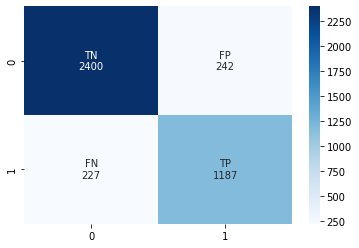

In [77]:
CNN_model_with_SMOTE_and_optimizer = create_model(5.0e-5, 0.001)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
batch_size = 78
epochs = 30
history = CNN_model_with_SMOTE_and_optimizer.fit(x_train_CNN_over, y_train_CNN_over,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test_CNN, y_test_CNN),
        shuffle=True, callbacks=[lr_reducer])
y_pred = CNN_model_with_SMOTE_and_optimizer.predict(x_test_CNN)
validate_CNN(y_test_CNN.argmax(axis=1), y_pred, "CNN with smote and optimizer applying gridsearch")

In [79]:
testPerformance

,Algorithm,F1,Recall,Precision,Accuracy
0,SVC base,0.841007,0.826733,0.855783,0.891026
1,SVC base with SMOTE,0.838596,0.84512,0.832173,0.886588
2,SVC Grid with SMOTE,0.835,0.826733,0.843434,0.886095
3,CNN,0.914448,0.914448,0.914448,0.914448
4,CNN,0.90927,0.90927,0.90927,0.90927
5,CNN model with smote,0.905079,0.905079,0.905079,0.905079
6,CNN with smote and optimizer applying gridsearch,0.884369,0.884369,0.884369,0.884369


# SETUP TASK 2


### Analysing
The second task of the project is aiming to construct a model that distinguishes images into 4 types of categories. Unlike task one, more than half of the data have not been labelled yet so we are unable to perform the supervised learning technique in this task. Based on our research, we find out that semi-supervised learning is the key to solving the problem. In brief, semi-supervised learning (SSL) is a machine learning technique that employs a little amount of labelled data and a large quantity of unlabeled data to train a forecasting model (AltexSoft). 
There are many methods, but we decided to use self-training, because it is the simplest example of semi-supervised learning, and we see that its workflow is suitable for our case which will be explained later in the report. Self-training is the procedure by which any supervised algorithm for classification or regression can be modified to operate semi-supervised, utilising both labelled and unlabeled data.(AltexSoft)
### Dataflow of self-learning
Similar to supervised learning, train the model with a modest amount of labelled training data until it produces satisfactory results. The best model is then used with the unlabeled training dataset to predict the outputs, which are pseudo labels because they may not be entirely precise. Then set a confident value in order to collect the most confident predictions. If any of the pseudo-labels are above this confidence threshold, they are added to the labelled dataset and create a new, combined input. After that, we will use these updated datasets to train an improved model. This process may complete multiple iterations with more and more pseudo-labels being added. Assuming the data is suitable for the procedure, the model's performance will continue to improve with each repetition. (AltexSoft)
### Implement
In our project, we will measure two CNN models with different architecture before starting the self-learning process. Finding which one has a better performance based on the validation loss and its accuracy. The reason we do this step is to find out the appropriate number of CNN layers which will treat overfitting in our model (Sagar). When we have successfully chosen the right model, it will be put into the self-training process. We decide to make 10 iterations or when the unlabeled dataset is empty, the process will stop. There are two reasons we choose only to run at most 10 iterations. The first one is based on AltexSoft, a technology consulting company, 10 is a standard amount in self-learning (AltexSoft). The second reason is we have tested the process and on the tenth iteration, the accuracy of the model has already been very high (85%) and the unlabeled dataset only reminds around 200 data while the original one is more than 10,000. The last thing is the confidence threshold, we decide to accept the prediction that is equal to or higher than 75%


In [282]:
from __future__ import print_function
import seaborn as sns
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import h5py
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [284]:
def load_data(dataPath): 
    PATH = os.getcwd()

    # Define data path
    maindata = pd.read_csv(dataPath)
    data_dir_list = maindata['ImageName']
    data_img_dir = "Image_classification_data/patch_images"
    img_data_list = []



    for dataset in data_dir_list:
        img_path =  data_img_dir + '/' + dataset

        img = image.load_img(img_path, target_size=(27,27))
        x = image.img_to_array(img)
        img_data_list.append(x)

    maindata["image"] = img_data_list
    return maindata

In [285]:
maindata = load_data("Image_classification_data/data_labels_mainData.csv")
extradata = load_data("Image_classification_data/data_labels_extraData.csv")

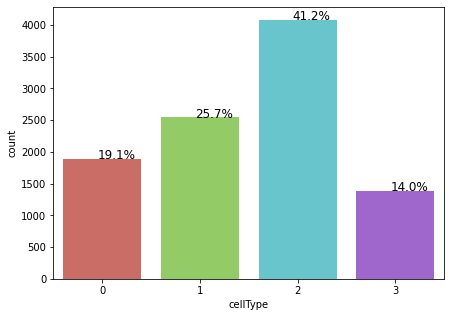

In [286]:
plt.figure(figsize= (7,5))
ax = sns.countplot(x = 'cellType', data = maindata, palette='hls')
without_hue(ax, maindata.isCancerous)

In [8]:
def reshape_27_27_3(data):
    data = np.reshape(data, (data.shape[0], 27, 27, 3))
    data = np.asarray(data)
    return data

In [9]:
from imblearn.over_sampling import SMOTE

X_cell, y_cell = target_and_y(maindata, 'cellType')
X_cell_2D = convert3Dto2D(X_cell)
x_train, x_test, y_train, y_test = train_test_split(X_cell_2D, y_cell, test_size=0.2,random_state=1234)

y_train.value_counts()

2    3303
1    2026
0    1475
3    1112
Name: cellType, dtype: int64

In [10]:
over = SMOTE(sampling_strategy= {0 :3303,1:3303,2:3303,3:3303}) 
x_train_with_SMOTE, y_train_with_SMOTE = over.fit_resample(x_train,y_train)
y_train_with_SMOTE.value_counts()

1    3303
2    3303
0    3303
3    3303
Name: cellType, dtype: int64

In [11]:
x_train_without_SMOTE = reshape_27_27_3(x_train)
x_train_with_SMOTE = reshape_27_27_3(x_train_with_SMOTE)
x_test = reshape_27_27_3(x_test)

In [12]:
# Perform one-hot encoding on the labels
y_train_without_SMOTE = to_categorical(y_train, num_classes = 4)
y_train_with_SMOTE = to_categorical(y_train_with_SMOTE, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

In [13]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
def model_1(learning_rate, epsilon):
    model_1 = Sequential()
    model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
    model_1.add(BatchNormalization())
    model_1.add(Conv2D(64, (3, 3), activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPool2D(pool_size=(2, 2)))

    model_1.add(Flatten())
    model_1.add(Dense(128, activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))
    model_1.add(Dense(128, activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))
    model_1.add(Dense(4, activation='softmax'))
    
    adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=1.0e-6,amsgrad=False)
    model_1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[f1])
    return model_1;

In [15]:
def model_2(learning_rate, epsilon):
    model_2 = Sequential()
    model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
    model_2.add(BatchNormalization())

    model_2.add(Conv2D(32, (3, 3), activation='relu'))
    model_2.add(BatchNormalization())

    model_2.add(MaxPool2D(pool_size=(2, 2)))

    model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_2.add(BatchNormalization())

    model_2.add(Conv2D(64, (3, 3), activation='relu'))
    model_2.add(BatchNormalization())

    model_2.add(MaxPool2D(pool_size=(2, 2)))

    model_2.add(Flatten())

    model_2.add(Dense(128, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))

    model_2.add(Dense(128, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))

    model_2.add(Dense(128, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))

    model_2.add(Dense(4, activation='softmax'))
    
    adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=1.0e-6,amsgrad=False)
    model_2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[f1])
    return model_2;

In [16]:
def train_model(model, x_train, y_train, x_test, y_test, epochs):
    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)

    batch_size = 78
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer])
    return history

In [17]:
import time

def plot_history(model, history, x_test, y_test):
    start_time = time.time()

    print("---  Training time in seconds ---%s " % (time.time() - start_time))
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Max Test accuracy:', max(history.history['val_f1']))
    # # visualizing losses and accuracy
    print(history.history.keys())
    # # summarize history for accuracy
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
def get_pseudo_label(predictions):
    result = []
    
    for data in predictions:
        max_value = np.max(data)
        data = np.where(data == max_value, 1, 0)
        result.append(data)
    result = np.array(result)
    return result;

In [19]:
model_1_without_SMOTE = model_1(0.00006, 1.0e-7)
history_model_1_without_SMOTE = train_model(model_1_without_SMOTE, 
                                            x_train_without_SMOTE, 
                                            y_train_without_SMOTE, 
                                            x_test, y_test, 40)

Epoch 1/40
102/102 [==============================] - 26s 245ms/step - loss: 1.1500 - f1: 0.5553 - val_loss: 3.8272 - val_f1: 0.2204 - lr: 6.0000e-05
Epoch 2/40
102/102 [==============================] - 25s 247ms/step - loss: 0.8021 - f1: 0.6891 - val_loss: 1.3034 - val_f1: 0.5403 - lr: 6.0000e-05
Epoch 3/40
102/102 [==============================] - 25s 247ms/step - loss: 0.6999 - f1: 0.7272 - val_loss: 0.7632 - val_f1: 0.6864 - lr: 6.0000e-05
Epoch 4/40
102/102 [==============================] - 25s 244ms/step - loss: 0.6394 - f1: 0.7531 - val_loss: 0.6836 - val_f1: 0.7348 - lr: 6.0000e-05
Epoch 5/40
102/102 [==============================] - 25s 245ms/step - loss: 0.5729 - f1: 0.7710 - val_loss: 0.6687 - val_f1: 0.7526 - lr: 6.0000e-05
Epoch 6/40
102/102 [==============================] - 25s 247ms/step - loss: 0.5202 - f1: 0.7926 - val_loss: 0.6739 - val_f1: 0.7491 - lr: 6.0000e-05
Epoch 7/40
102/102 [==============================] - 28s 274ms/step - loss: 0.4685 - f1: 0.8171 - v

In [20]:
model_1_with_SMOTE = model_1(0.00006, 1.0e-7)
history_model_1_with_SMOTE = train_model(model_1_with_SMOTE, 
                                            x_train_with_SMOTE, 
                                            y_train_with_SMOTE, 
                                            x_test, y_test, 40)

Epoch 1/40
170/170 [==============================] - 42s 240ms/step - loss: 1.0553 - f1: 0.5825 - val_loss: 1.8765 - val_f1: 0.4078 - lr: 6.0000e-05
Epoch 2/40
170/170 [==============================] - 42s 247ms/step - loss: 0.7463 - f1: 0.6998 - val_loss: 0.7697 - val_f1: 0.7076 - lr: 6.0000e-05
Epoch 3/40
170/170 [==============================] - 41s 240ms/step - loss: 0.6163 - f1: 0.7532 - val_loss: 0.8014 - val_f1: 0.6957 - lr: 6.0000e-05
Epoch 4/40
170/170 [==============================] - 41s 240ms/step - loss: 0.5298 - f1: 0.7956 - val_loss: 0.7994 - val_f1: 0.7048 - lr: 6.0000e-05
Epoch 5/40
170/170 [==============================] - 41s 239ms/step - loss: 0.4474 - f1: 0.8291 - val_loss: 0.8665 - val_f1: 0.7073 - lr: 6.0000e-05
Epoch 6/40
170/170 [==============================] - 41s 241ms/step - loss: 0.3794 - f1: 0.8597 - val_loss: 0.8509 - val_f1: 0.7077 - lr: 6.0000e-05
Epoch 7/40
170/170 [==============================] - 42s 246ms/step - loss: 0.3249 - f1: 0.8838 - v

In [21]:
model_2_without_SMOTE = model_2(0.00006, 1.0e-7)
history_model_2_without_SMOTE = train_model(model_2_without_SMOTE, 
                                            x_train_without_SMOTE, 
                                            y_train_without_SMOTE, 
                                            x_test, y_test, 40)

Epoch 1/40
102/102 [==============================] - 19s 177ms/step - loss: 1.5251 - f1: 0.3723 - val_loss: 1.7732 - val_f1: 0.0232 - lr: 6.0000e-05
Epoch 2/40
102/102 [==============================] - 17s 167ms/step - loss: 1.0718 - f1: 0.5595 - val_loss: 1.3466 - val_f1: 0.3620 - lr: 6.0000e-05
Epoch 3/40
102/102 [==============================] - 17s 171ms/step - loss: 0.9539 - f1: 0.6194 - val_loss: 0.8042 - val_f1: 0.6607 - lr: 6.0000e-05
Epoch 4/40
102/102 [==============================] - 16s 160ms/step - loss: 0.8831 - f1: 0.6514 - val_loss: 0.7725 - val_f1: 0.6982 - lr: 6.0000e-05
Epoch 5/40
102/102 [==============================] - 16s 159ms/step - loss: 0.8329 - f1: 0.6720 - val_loss: 0.7951 - val_f1: 0.6837 - lr: 6.0000e-05
Epoch 6/40
102/102 [==============================] - 16s 157ms/step - loss: 0.7865 - f1: 0.6910 - val_loss: 0.7268 - val_f1: 0.7186 - lr: 6.0000e-05
Epoch 7/40
102/102 [==============================] - 16s 159ms/step - loss: 0.7615 - f1: 0.7027 - v

In [22]:
model_2_with_SMOTE = model_2(0.00006, 1.0e-7)
history_model_2_with_SMOTE = train_model(model_2_with_SMOTE, 
                                            x_train_with_SMOTE, 
                                            y_train_with_SMOTE, 
                                            x_test, y_test, 40)

Epoch 1/40
170/170 [==============================] - 30s 160ms/step - loss: 1.4156 - f1: 0.4337 - val_loss: 1.0741 - val_f1: 0.5340 - lr: 6.0000e-05
Epoch 2/40
170/170 [==============================] - 27s 157ms/step - loss: 1.0574 - f1: 0.5751 - val_loss: 0.8384 - val_f1: 0.6497 - lr: 6.0000e-05
Epoch 3/40
170/170 [==============================] - 26s 155ms/step - loss: 0.9301 - f1: 0.6177 - val_loss: 0.8231 - val_f1: 0.6583 - lr: 6.0000e-05
Epoch 4/40
170/170 [==============================] - 26s 156ms/step - loss: 0.8574 - f1: 0.6513 - val_loss: 0.7878 - val_f1: 0.6781 - lr: 6.0000e-05
Epoch 5/40
170/170 [==============================] - 26s 154ms/step - loss: 0.7916 - f1: 0.6752 - val_loss: 0.7408 - val_f1: 0.7121 - lr: 6.0000e-05
Epoch 6/40
170/170 [==============================] - 26s 154ms/step - loss: 0.7381 - f1: 0.7027 - val_loss: 0.7491 - val_f1: 0.6995 - lr: 6.0000e-05
Epoch 7/40
170/170 [==============================] - 26s 155ms/step - loss: 0.6943 - f1: 0.7209 - v

Model 1 without SMOTE
---  Training time in seconds ---0.0 
62/62 [==============================] - 2s 26ms/step - loss: 0.7192 - f1: 0.7517
Test loss: 0.7191538214683533
Test accuracy: 0.751664400100708
Max Test accuracy: 0.7570677995681763
dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])


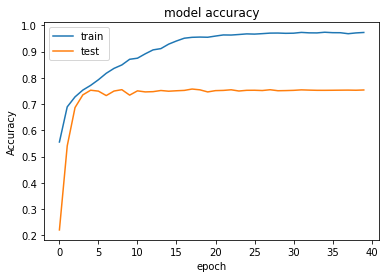

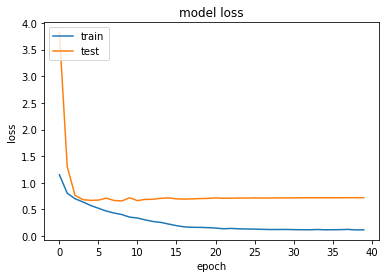

In [23]:
print("Model 1 without SMOTE")
plot_history(model_1_without_SMOTE, history_model_1_without_SMOTE, x_test, y_test)

Model 1 with SMOTE
---  Training time in seconds ---0.0 
62/62 [==============================] - 2s 25ms/step - loss: 0.8648 - f1: 0.7226
Test loss: 0.864788830280304
Test accuracy: 0.7226330041885376
Max Test accuracy: 0.7241151332855225
dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])


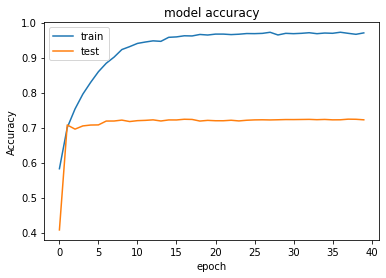

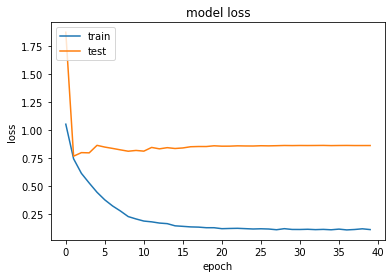

In [24]:
print("Model 1 with SMOTE")
plot_history(model_1_with_SMOTE, history_model_1_with_SMOTE, x_test, y_test)

Model 2 without SMOTE
---  Training time in seconds ---0.0 
62/62 [==============================] - 1s 17ms/step - loss: 0.7129 - f1: 0.7382
Test loss: 0.7129281759262085
Test accuracy: 0.7382480502128601
Max Test accuracy: 0.7439548969268799
dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])


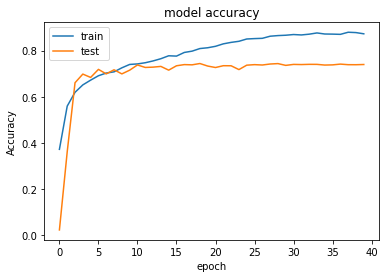

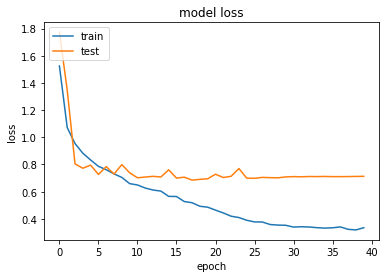

In [25]:
print("Model 2 without SMOTE")
plot_history(model_2_without_SMOTE, history_model_2_without_SMOTE, x_test, y_test)

Model 2 with SMOTE
---  Training time in seconds ---0.0 
62/62 [==============================] - 1s 19ms/step - loss: 0.7410 - f1: 0.7596
Test loss: 0.7410005927085876
Test accuracy: 0.7596395611763
Max Test accuracy: 0.7632191777229309
dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])


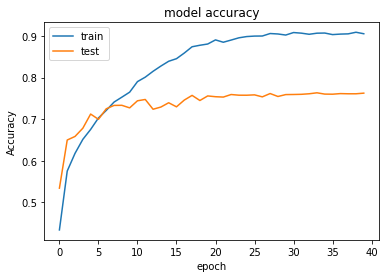

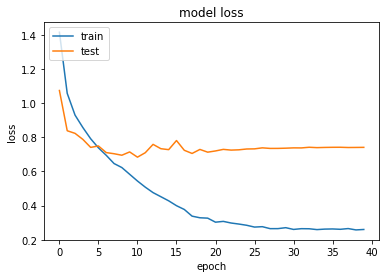

In [26]:
print("Model 2 with SMOTE")
plot_history(model_2_with_SMOTE, history_model_2_with_SMOTE, x_test, y_test)

In [31]:
predictions_mdl1_without_SMOTE = model_1_without_SMOTE.predict(x=x_test, steps=len(x_test), verbose=1)
predictions_mdl1_with_SMOTE = model_1_with_SMOTE.predict(x=x_test, steps=len(x_test), verbose=1)
predictions_mdl2_without_SMOTE = model_2_without_SMOTE.predict(x=x_test, steps=len(x_test), verbose=1)
predictions_mdl2_with_SMOTE = model_1_with_SMOTE.predict(x=x_test, steps=len(x_test), verbose=1)

1980/1980 [==============================] - 6s 3ms/step


In [32]:
pseudo_mdl1_without_SMOTE = get_pseudo_label(predictions_mdl1_without_SMOTE)
pseudo_mdl1_with_SMOTE = get_pseudo_label(predictions_mdl1_with_SMOTE)
pseudo_mdl2_without_SMOTE = get_pseudo_label(predictions_mdl2_without_SMOTE)
pseudo_mdl2_with_SMOTE = get_pseudo_label(predictions_mdl2_with_SMOTE)

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [87]:
print("Model 1 without SMOTE")
print(classification_report(y_test, pseudo_mdl1_without_SMOTE))

Model 1 without SMOTE
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       413
           1       0.69      0.77      0.73       517
           2       0.86      0.90      0.88       776
           3       0.56      0.47      0.51       274

   micro avg       0.75      0.75      0.75      1980
   macro avg       0.71      0.69      0.70      1980
weighted avg       0.75      0.75      0.75      1980
 samples avg       0.75      0.75      0.75      1980



In [43]:
print("Model 1 with SMOTE")
print(classification_report(y_test, pseudo_mdl1_with_SMOTE))

Model 1 with SMOTE
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       413
           1       0.68      0.72      0.70       517
           2       0.84      0.87      0.86       776
           3       0.49      0.44      0.46       274

   micro avg       0.72      0.72      0.72      1980
   macro avg       0.67      0.66      0.67      1980
weighted avg       0.72      0.72      0.72      1980
 samples avg       0.72      0.72      0.72      1980



In [44]:
print("Model 2 without SMOTE")
print(classification_report(y_test, pseudo_mdl2_without_SMOTE))

Model 2 without SMOTE
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       413
           1       0.66      0.75      0.70       517
           2       0.86      0.90      0.88       776
           3       0.55      0.45      0.49       274

   micro avg       0.74      0.74      0.74      1980
   macro avg       0.70      0.68      0.68      1980
weighted avg       0.73      0.74      0.73      1980
 samples avg       0.74      0.74      0.74      1980



In [45]:
print("Model 2 with SMOTE")
print(classification_report(y_test, pseudo_mdl2_with_SMOTE))

Model 2 with SMOTE
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       413
           1       0.68      0.72      0.70       517
           2       0.84      0.87      0.86       776
           3       0.49      0.44      0.46       274

   micro avg       0.72      0.72      0.72      1980
   macro avg       0.67      0.66      0.67      1980
weighted avg       0.72      0.72      0.72      1980
 samples avg       0.72      0.72      0.72      1980



### Evaluate to get the best model
Because we decide to use the macro f1 score to evaluate our model, based on the reports above, model 1 without SMOTE has the best performance which is 0.7. We have also considered the micro average value because the data after SMOTE is already balanced in each class. However, the micro f1 score of model 1 without SMOTE is still the highest. Therefore, we decide to choose this model to apply to the self-training process.

In [63]:
x_unlabel = extradata['image']
x_unlabel = convert3Dto2D(x_unlabel)
x_unlabel = np.reshape(x_unlabel, (x_unlabel.shape[0], 27, 27, 3))

In [64]:
def add_confident(predictions, x_train, y_train, x_unlabel):
    index = 0
    confident_pred = []

    for data in predictions:
        max_value = np.max(data)
        if max_value / 1 * 100 >= 75:
            x_train = np.append(x_train, [x_unlabel[index]], axis=0)
            y_train = np.append(y_train, np.round([data]), axis=0)
            confident_pred.append(index)
        index+=1
    x_unlabel = np.delete(x_unlabel, confident_pred, axis=0)
    return x_train, y_train, x_unlabel;

In [69]:
def self_training(x_train, y_train, x_unlabel, x_test, y_test):
    iteration = 0;
    while iteration < 10 or x_unlabel.size == 0:
        print('Iteration: ', iteration + 1)
        print('Training phase')
        training_model = model_1(0.00006, 1.0e-7)

        history = train_model(training_model, x_train, y_train, x_test, y_test, 5)
        
        print('Predict phase')
        predictions = training_model.predict(x=x_unlabel, steps=len(x_unlabel), verbose=1)
        
        print('Update phase')
        x_train, y_train, x_unlabel = add_confident(predictions, x_train, y_train, x_unlabel)
        
        iteration+=1
    return training_model, history;

The above function is to start the self-training process. We keep the learning rate and the epsilon parameters the same and pass the dataset that has been applied SMOTE in order to produce the base model 1. However, based on the validation loss graph of model 1 without SMOTE, we see that the model starts to overfitting when it trains with the epoch larger than 5 so we set this parameter to 5 in order to get the best accuracy.

In [70]:
final_model, fm_history = self_training(x_train_without_SMOTE, y_train_without_SMOTE, x_unlabel, x_test, y_test)

Iteration:  1
Training phase
Epoch 1/5
102/102 [==============================] - 26s 246ms/step - loss: 1.0940 - f1: 0.5709 - val_loss: 2.8022 - val_f1: 0.3427 - lr: 6.0000e-05
Epoch 2/5
102/102 [==============================] - 26s 253ms/step - loss: 0.7758 - f1: 0.6992 - val_loss: 1.0568 - val_f1: 0.5881 - lr: 6.0000e-05
Epoch 3/5
102/102 [==============================] - 26s 252ms/step - loss: 0.6857 - f1: 0.7344 - val_loss: 0.7621 - val_f1: 0.6946 - lr: 6.0000e-05
Epoch 4/5
102/102 [==============================] - 26s 256ms/step - loss: 0.6141 - f1: 0.7552 - val_loss: 0.6630 - val_f1: 0.7384 - lr: 6.0000e-05
Epoch 5/5
102/102 [==============================] - 26s 254ms/step - loss: 0.5500 - f1: 0.7864 - val_loss: 0.6901 - val_f1: 0.7306 - lr: 6.0000e-05
Predict phase
10384/10384 [==============================] - 33s 3ms/step
Update phase
Iteration:  2
Training phase
Epoch 1/5
190/190 [==============================] - 48s 249ms/step - loss: 0.8211 - f1: 0.7074 - val_loss: 0.

In [72]:
predictions_mdl2 = final_model.predict(x=x_test, steps=len(x_test), verbose=1)


1980/1980 [==============================] - 6s 3ms/step


In [73]:
test_set_pred = get_pseudo_label(predictions_mdl2)

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


print(classification_report(y_test, test_set_pred))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       413
           1       0.67      0.82      0.74       517
           2       0.86      0.89      0.88       776
           3       0.61      0.38      0.47       274

   micro avg       0.75      0.75      0.75      1980
   macro avg       0.71      0.68      0.69      1980
weighted avg       0.75      0.75      0.74      1980
 samples avg       0.75      0.75      0.75      1980



In [76]:
print(f1_score(y_test, test_set_pred, average = 'macro'))

0.6892345441354881


<h1>Ultimate Judgment</h1>


After 10 iterations of self-training, the macro f1 score of our model is 0.69. Although we have applied a semi-supervised technique to attempt to get a better model, the performance of the model is unchanged. This task aims to train a model that has better performance than the softmax CNN + NEP model on classification cell type. We have come up with a judgment on the model:

Although both datasets have almost the same amount of images, more than half of them are unlabelled so we must apply semi-supervised learning to finish the task. According to AltexSoft, the performance of the SSL model depends on the base model that is trained on the labeled dataset (AltexSoft). If the performance has already been bad at the beginning, it will lead to inferior performance. Although we have tried many methods like data augmentation (SMOTE) or tried different architecture complexity CNN models, we cannot get a better classifier. Therefore, we accept the result and try to look for a new method to increase the performance like applying class weight instead of SMOTE.

In the report above, the f1 score for this type is 0.88. Hence, although the average score is quite low, with our model, we can be confident in identifying the Epithelial cell type.

The limitation of the model is very obvious. When the accuracy of our model is quite low, we cannot be confident in the prediction of the model. Especially, the Miscellaneous which is only 0.47 on the f1 score.

In order to improve the model, we will try to use some methods to increase the performance. The first one is finding bigger pre-trained data if it is impossible. This is the easiest way to improve the validation accuracy. The second way is trying to resize the image to a bigger size. If we select an image size that is too small, our model will be unable to detect the distinguishing characteristics that aid in image recognition.